<a href="https://colab.research.google.com/github/kilbridc/lacrosse_ML/blob/main/Final_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Web Scraping

In [ ]:
# imports
from bs4 import BeautifulSoup
import pandas as pd
import requests
from datetime import datetime, timedelta

## Scraping the Game Scores

First, we will get the scores from 2017-2024 data. 2016 has bad data and 2025 is not a complete season yet.

In [ ]:
# scores URL
url = "https://www.ncaa.com/scoreboard/lacrosse-men/d1/2025/04/23/all-conf"
page = requests.get(url)
soup = BeautifulSoup(page.text, "html")

#soup

Now we will scrape this URL to get all of the scores from these seasons. For this, I simply manipulated the URL to get each date.

In [ ]:
# all season scores
from bs4 import BeautifulSoup
import pandas as pd
import requests
from datetime import datetime, timedelta

all_results = []

# Loop through each season from 2016 to 2024, Feb 1st to May 30th
for year in range(2017, 2025):
    start_date = datetime(year, 2, 1)
    end_date = datetime(year, 5, 30)
    current_date = start_date

    while current_date <= end_date:
        # Format URL and date strings
        url_date = current_date.strftime("%Y/%m/%d")
        formatted_date = current_date.strftime("%Y-%m-%d")
        url = f"https://www.ncaa.com/scoreboard/lacrosse-men/d1/{url_date}"

        print(f"Scraping {formatted_date}...")

        # Send request
        headers = {
            "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/123.0.0.0 Safari/537.36"
        }
        try:
            response = requests.get(url, headers=headers, timeout=15)
            if response.status_code != 200:
                print(f"  Failed to load {formatted_date}")
                current_date += timedelta(days=1)
                continue

            soup = BeautifulSoup(response.text, "html.parser")
            games = soup.find_all("div", class_="gamePod")

            for game in games:
                teams = game.find_all("li")
                if len(teams) != 2:
                    continue

                try:
                    team_1 = teams[0].find("span", class_="gamePod-game-team-name").text.strip()
                    score_1 = teams[0].find("span", class_="gamePod-game-team-score").text.strip()

                    team_2 = teams[1].find("span", class_="gamePod-game-team-name").text.strip()
                    score_2 = teams[1].find("span", class_="gamePod-game-team-score").text.strip()

                    team_1_is_winner = "winner" in teams[0].get("class", [])

                    all_results.append({
                        "Date": formatted_date,
                        "Year": year,
                        "Team 1": team_1,
                        "Score 1": score_1,
                        "Team 2": team_2,
                        "Score 2": score_2,
                        "Winner": team_1 if team_1_is_winner else team_2
                    })
                except:
                    continue

        except Exception as e:
            print(f"  Error loading {formatted_date}: {e}")

        current_date += timedelta(days=1)

# Create DataFrame
df_all_seasons = pd.DataFrame(all_results)
print("\n✅ Scraping complete!")
df_all_seasons.head()


Scraping 2017-02-01...
Scraping 2017-02-02...
Scraping 2017-02-03...
Scraping 2017-02-04...
Scraping 2017-02-05...
Scraping 2017-02-06...
Scraping 2017-02-07...
Scraping 2017-02-08...
Scraping 2017-02-09...
Scraping 2017-02-10...
Scraping 2017-02-11...
Scraping 2017-02-12...
Scraping 2017-02-13...
Scraping 2017-02-14...
Scraping 2017-02-15...
Scraping 2017-02-16...
Scraping 2017-02-17...
Scraping 2017-02-18...
Scraping 2017-02-19...
Scraping 2017-02-20...
Scraping 2017-02-21...
Scraping 2017-02-22...
Scraping 2017-02-23...
Scraping 2017-02-24...
Scraping 2017-02-25...
Scraping 2017-02-26...
Scraping 2017-02-27...
Scraping 2017-02-28...
Scraping 2017-03-01...
Scraping 2017-03-02...
Scraping 2017-03-03...
Scraping 2017-03-04...
Scraping 2017-03-05...
Scraping 2017-03-06...
Scraping 2017-03-07...
Scraping 2017-03-08...
Scraping 2017-03-09...
Scraping 2017-03-10...
Scraping 2017-03-11...
Scraping 2017-03-12...
Scraping 2017-03-13...
Scraping 2017-03-14...
Scraping 2017-03-15...
Scraping 20

,Date,Year,Team 1,Score 1,Team 2,Score 2,Winner
0,2017-02-04,2017,Bucknell,14,Delaware,13,Bucknell
1,2017-02-04,2017,Boston U.,8,Providence,7,Boston U.
2,2017-02-04,2017,UMBC,6,North Carolina,17,North Carolina
3,2017-02-04,2017,Michigan,13,Cleveland St.,8,Michigan
4,2017-02-04,2017,NJIT,5,Lehigh,15,Lehigh


I will save this dataframe to a csv, so I don't have to re-scrape this.

In [ ]:
# make into csv
df_all_seasons.to_csv("ncaa_lacrosse_all_seasons.csv", index=False)
# save to drive
!cp ncaa_lacrosse_all_seasons.csv "/content/drive/MyDrive/Colab Notebooks/Final Project Real Folder/Raw Data"

## Scraping the statistics

This website was a little more difficult, so I used different headers to get in.

This is the function to scrape a single statistic from this website. It takes a stat_seq, which is how each statistic is reffered to in the URL.

We can see this by looking at a URL.
https://stats.ncaa.org/rankings/national_ranking?academic_year=2024.0&division=1.0&ranking_period=9.0&sport_code=MLA&stat_seq=561.0
We can see the different arguments (separated by &), and by messing with these in browser, we can understand what they do.

In [ ]:
# example URL:
# https://stats.ncaa.org/rankings/national_ranking?academic_year=2024.0&division=1.0&ranking_period=9.0&sport_code=MLA&stat_seq=561.0
# need

def scrape_ncaa_stat(start_year, end_year, stat_seq):
    """
    Scrapes NCAA stats for a specific stat category (by stat_seq) over multiple academic years.

    """

    # these are for the URL
    sport_code = "MLA"
    division = "1.0"
    base_url = "https://stats.ncaa.org/rankings/national_ranking"

    headers = {
        "User-Agent": "Mozilla/5.0",
        "Referer": "https://www.stats.ncaa.org/"
    }

    academic_years = [f"{y}.0" for y in range(start_year, end_year + 1)]

    all_stats = []

    for year in academic_years:
        print(f"\n📅 Scraping Academic Year: {year}")

        # had to use ranking period of 24.0, then reverse back to the first entry, because every stat/year has one ranking with 24.0
        params = {
            "academic_year": year,
            "division": division,
            "ranking_period": "24.0",
            "sport_code": sport_code,
            "stat_seq": stat_seq
        }

        try:
            response = requests.get(base_url, headers=headers, params=params, timeout=15)
            soup = BeautifulSoup(response.text, "html.parser")
            options = soup.select("select#rp option")
        except Exception as e:
            print(f"    ❌ Failed to load base page for year {year}: {e}")
            continue

        if not options:
            print(f"    ⚠️ No ranking periods found for year {year}")
            continue

        # this gets the list of all of the dates for that year
        ranking_periods = [(opt["value"], opt.text.strip()) for opt in options]
        print(f"    ↳ Found {len(ranking_periods)} ranking periods")

        # this goes through all of the dates
        for rp_value, date in ranking_periods:
            print(f"    → Scraping {date} (rp={rp_value})")

            params["ranking_period"] = rp_value
            try:
                rp_response = requests.get(base_url, headers=headers, params=params, timeout=15)
                rp_soup = BeautifulSoup(rp_response.text, "html.parser")
            except Exception as e:
                print(f"      ⚠️  Failed for {date}: {e}")
                continue

            header_row = rp_soup.find("tr", class_="splash_col_heading")
            if not header_row:
                print(f"      ⚠️ No header found for {date}")
                continue

            column_names = [th.text.strip() for th in header_row.find_all("th")]

            data_rows = rp_soup.find_all("tr")
            for row in data_rows:
                cols = row.find_all("td")
                if len(cols) == len(column_names):
                    try:
                        values = [col.text.strip() for col in cols]
                        stat_dict = dict(zip(column_names, values))
                        stat_dict["Date"] = date
                        stat_dict["Academic Year"] = year
                        all_stats.append(stat_dict)
                    except Exception:
                        continue

    # Create DataFrame
    df = pd.DataFrame(all_stats)


    return df


This code actually runs the previous function, but using all of the stat_categories. For each statistic, this code saves a new csv to my Raw Data Folder, and inside of the Statistics folder. This will take hours to run, so make sure your computer is charged

In [ ]:
# Statistics you want to scrape
stat_categories = {
    "Assists per Game": "535.0",
    "Caused Turnovers per Game": "561.0",
    "Clearing %": "838.0",
    "Faceoff %": "230.0",
    "Groundballs per Game": "538.0",
    "Man Down Defense": "232.0",
    "Man Up Offense": "231.0",
    "Opponent Clear %": "1213.0",
    "Scoring Offense": "228.0",
    "Saves per Game": "536.0",
    "Scoring Defense": "229.0",
    "Scoring Margin": "238.0",
    "Shot %": "563.0",
    "Turnovers per Game": "559.0"
}

# for loop that loops through all of the statistics above and saves hem to there
for stat_name, stat_seq in stat_categories.items():
    print(f"\n🔍 Scraping: {stat_name} (stat_seq={stat_seq})")

    df = scrape_ncaa_stat(start_year=2015, end_year=2024, stat_seq=stat_seq)

    # Create clean filename
    safe_stat_name = stat_name.lower().replace(" ", "_").replace("%", "percent").replace("/", "_per_")
    filename = f"ncaa_{safe_stat_name}_2017_2024.csv"

    # Save to Google Drive
    save_path = f"/content/drive/MyDrive/Colab Notebooks/Final Project Real Folder/Raw Data/Statistics/{filename}"
    df.to_csv(save_path, index=False)

    print(f"✅ Saved to {save_path}")


# Data Cleaning and Merging

## Cleaning Individual Sheets

Right now, all of the data is stored in my drive, and it's all on different notebooks. The goal of this section is to combine all of the statistics into one cohesive .csv file.

In [ ]:
# imports
import pandas as pd
import os
from tqdm.notebook import tqdm

The first thing we need to do is only keep the data columns we want.

In [ ]:
# function to clean a sheet
# this will take the name of the sheet, and find the statistic associated with it, and remove the rest
# for special ones (ones that don't match), we created rename_mapping to help us

def clean_statistic(statistic_name, column_to_keep):
    """
    Cleans a lacrosse statistic dataset with custom naming rules.

    Args:
        statistic_name (str): The original name of the statistic.
        column_to_keep (str): The column to keep from the raw file.

    Saves:
        A cleaned CSV with corrected statistic naming.
    """

    # Mapping for special renames
    rename_mapping = {
        "Scoring Offense": "Goals per Game",
        "Scoring Defense": "Goals Allowed per Game",
        "Scoring Margin": "Average Margin",
        "Man Down Defense": "Man Down Defense Percent",
        "Man Up Offense": "Man Up Offense Percent"
    }

    # Get the final name to use
    final_stat_name = rename_mapping.get(statistic_name, statistic_name)

    # Convert original statistic name to filename-friendly format
    filename_stat = statistic_name.lower().replace(' ', '_')
    file_path = f'/content/drive/MyDrive/Colab Notebooks/Final Project Real Folder/Raw Data/Statistics/ncaa_{filename_stat}_2017_2024.csv'

    # Load the dataset
    df = pd.read_csv(file_path)

    # Keep only the necessary columns
    df = df[['Date', 'Team', column_to_keep]]

    # Rename the important column to the final name
    df = df.rename(columns={column_to_keep: final_stat_name})

    # Clean the Date column (first 10 characters only)
    df['Date'] = df['Date'].str.slice(0, 10)

    # Convert Date to datetime
    df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y')

    # Make sure the output folder exists
    output_folder = '/content/drive/MyDrive/Colab Notebooks/Final Project Real Folder/Clean Data'
    os.makedirs(output_folder, exist_ok=True)

    # Save the cleaned file
    cleaned_file_path = f'{output_folder}/clean_ncaa_{filename_stat}_2017_2024.csv'
    df.to_csv(cleaned_file_path, index=False)

    print(f"Saved cleaned data for '{final_stat_name}' to {cleaned_file_path}")


In [ ]:
# Statistic to column mapping
statistics = {
    "Assists per Game": "Per Game",
    "Caused Turnovers per Game": "Per Game",
    "Clearing Percent": "Pct.",
    "Faceoff Percent": "Pct.",
    "Groundballs per Game": "Per Game",
    "Man Down Defense": "Pct.",
    "Man Up Offense": "Pct.",
    "Opponent Clear Percent": "Pct.",
    "Scoring Offense": "Per Game",
    "Saves per Game": "Per Game",
    "Scoring Defense": "Per Game",
    "Scoring Margin": "Margin",
    "Shot Percent": "Pct.",
    "Turnovers per Game": "Per Game"
}

# Loop and apply cleaning
for stat_name, column_name in statistics.items():
    clean_statistic(stat_name, column_name)

Saved cleaned data for 'Assists per Game' to /content/drive/MyDrive/Colab Notebooks/Final Project Real Folder/Clean Data/clean_ncaa_assists_per_game_2017_2024.csv
Saved cleaned data for 'Caused Turnovers per Game' to /content/drive/MyDrive/Colab Notebooks/Final Project Real Folder/Clean Data/clean_ncaa_caused_turnovers_per_game_2017_2024.csv
Saved cleaned data for 'Clearing Percent' to /content/drive/MyDrive/Colab Notebooks/Final Project Real Folder/Clean Data/clean_ncaa_clearing_percent_2017_2024.csv
Saved cleaned data for 'Faceoff Percent' to /content/drive/MyDrive/Colab Notebooks/Final Project Real Folder/Clean Data/clean_ncaa_faceoff_percent_2017_2024.csv
Saved cleaned data for 'Groundballs per Game' to /content/drive/MyDrive/Colab Notebooks/Final Project Real Folder/Clean Data/clean_ncaa_groundballs_per_game_2017_2024.csv
Saved cleaned data for 'Man Down Defense Percent' to /content/drive/MyDrive/Colab Notebooks/Final Project Real Folder/Clean Data/clean_ncaa_man_down_defense_2017

## Merging the Data

The first thing we need to do is remove all of the parathesis from the statistics' sheets' team names, that way they match the games sheet.

In [ ]:
# Folder path with the existing cleaned stat files
folder_path = '/content/drive/MyDrive/Colab Notebooks/Final Project Real Folder/Clean Data'

# Loop through all CSVs in the folder
for file_name in os.listdir(folder_path):
    if file_name.endswith('.csv'):
        file_path = os.path.join(folder_path, file_name)

        # Load the file
        df = pd.read_csv(file_path)

        # If 'Team' column exists, clean it
        if 'Team' in df.columns:
            df['Team'] = df['Team'].str.split('(').str[0].str.strip()

        # Save it back to the same file (overwrite)
        df.to_csv(file_path, index=False)
        print(f"Cleaned and overwritten: {file_name}")

Cleaned and overwritten: clean_ncaa_assists_per_game_2017_2024.csv
Cleaned and overwritten: clean_ncaa_clearing_percent_2017_2024.csv
Cleaned and overwritten: clean_ncaa_groundballs_per_game_2017_2024.csv
Cleaned and overwritten: clean_ncaa_saves_per_game_2017_2024.csv
Cleaned and overwritten: clean_ncaa_man_down_defense_2017_2024.csv
Cleaned and overwritten: clean_ncaa_scoring_offense_2017_2024.csv
Cleaned and overwritten: clean_ncaa_caused_turnovers_per_game_2017_2024.csv
Cleaned and overwritten: clean_ncaa_faceoff_percent_2017_2024.csv
Cleaned and overwritten: clean_ncaa_opponent_clear_percent_2017_2024.csv
Cleaned and overwritten: clean_ncaa_man_up_offense_2017_2024.csv
Cleaned and overwritten: clean_ncaa_scoring_defense_2017_2024.csv
Cleaned and overwritten: clean_ncaa_scoring_margin_2017_2024.csv
Cleaned and overwritten: clean_ncaa_turnovers_per_game_2017_2024.csv
Cleaned and overwritten: clean_ncaa_shot_percent_2017_2024.csv


When you look at the games csv, there are a couple of errors. First, we need to normalize both team names and the winner. In addition, some of the names are very inconsistent. We fix both of these issues below.

Beyond this, we need to combine the sheets together. Since the date on the game sheet is the date of the game, we want the closest associated statistic BEFORE the game.

In [ ]:
# Load game data
games_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Final Project Real Folder/Raw Data/ncaa_lacrosse_all_seasons.csv')
games_df['Date'] = pd.to_datetime(games_df['Date'])

# Normalize
games_df['Team 1'] = games_df['Team 1'].str.strip().str.lower()
games_df['Team 2'] = games_df['Team 2'].str.strip().str.lower()
games_df['Winner'] = games_df['Winner'].str.strip().str.lower()

# === Team name corrections ===
name_corrections = {
    "albany": "ualbany",
    "albany (ny)": "ualbany",
    "army": "army west point",
    "cleveland": "cleveland st.",
    "detroit": "detroit mercy",
    "loyola (md.)": "loyola maryland",
    "mass.-lowell": "umass lowell",
    "mt. st. mary's": "mount st. mary's",
    "queens (nc)": "queens",
    "st. john's (ny)": "st. john's"
}

# Apply corrections
games_df['Team 1'] = games_df['Team 1'].replace(name_corrections)
games_df['Team 2'] = games_df['Team 2'].replace(name_corrections)

The following function will take a games dataframe, and a stat dataframe, and combine them based on the team name.

In [ ]:
def add_stat_to_games(games_df, stat_df, stat_column, output_column_base):
    """
    Adds pre-game statistics for Team 1 and Team 2 to a game dataframe.

    Args:
        games_df: DataFrame containing game data with 'Date', 'Year', 'Team 1', 'Team 2'
        stat_df: DataFrame with stats per team per date
        stat_column: Name of the statistic column in stat_df (e.g., 'Assists per Game')
        output_column_base: Base name for new columns (e.g., 'Assists per Game')

    Returns:
        games_df with two new columns added:
        - f'Team 1 {output_column_base}'
        - f'Team 2 {output_column_base}'
    """

    # Ensure dates are datetime
    games_df['Date'] = pd.to_datetime(games_df['Date'])
    stat_df['Date'] = pd.to_datetime(stat_df['Date'])

    # ensure everything is normalized
    games_df['Team 1'] = games_df['Team 1'].str.strip().str.lower()
    games_df['Team 2'] = games_df['Team 2'].str.strip().str.lower()
    stat_df['Team'] = stat_df['Team'].str.strip().str.lower()

    # Sort stats for efficient lookup
    stat_df = stat_df.sort_values(by=['Team', 'Date'])

    # Lookup function BEFORE the date of game
    def get_stat(team, date, year):
        records = stat_df[(stat_df['Team'] == team) &
                          (stat_df['Date'] < date) &
                          (stat_df['Date'].dt.year == year)]
        if records.empty:
            return ''
        return records.iloc[-1][stat_column]

    # Apply to Team 1
    games_df[f'Team 1 {output_column_base}'] = games_df.apply(
        lambda row: get_stat(row['Team 1'], row['Date'], row['Year']),
        axis=1
    )

    # Apply to Team 2
    games_df[f'Team 2 {output_column_base}'] = games_df.apply(
        lambda row: get_stat(row['Team 2'], row['Date'], row['Year']),
        axis=1
    )

    return games_df


In [ ]:
# Folder for stat files
stat_folder = '/content/drive/MyDrive/Colab Notebooks/Final Project Real Folder/Clean Data'

# Stat columns and filenames
statistics = {
    "Assists per Game": "assists_per_game",
    "Caused Turnovers per Game": "caused_turnovers_per_game",
    "Clearing Percent": "clearing_percent",
    "Faceoff Percent": "faceoff_percent",
    "Groundballs per Game": "groundballs_per_game",
    "Man Down Defense Percent": "man_down_defense",
    "Man Up Offense Percent": "man_up_offense",
    "Opponent Clear Percent": "opponent_clear_percent",
    "Goals per Game": "scoring_offense",
    "Saves per Game": "saves_per_game",
    "Goals Allowed per Game": "scoring_defense",
    "Average Margin": "scoring_margin",
    "Shot Percent": "shot_percent",
    "Turnovers per Game": "turnovers_per_game"
}

# Loop through each stat and add it to the game data
for stat_column_name, file_key in statistics.items():
    stat_file = f'{stat_folder}/clean_ncaa_{file_key}_2017_2024.csv'
    if os.path.exists(stat_file):
        print(f"Processing {stat_column_name} from {file_key}...")
        stat_df = pd.read_csv(stat_file)
        games_df = add_stat_to_games(games_df, stat_df, stat_column=stat_column_name, output_column_base=stat_column_name)
    else:
        print(f"File not found: {stat_file}")

# Save final game data
output_path = '/content/drive/MyDrive/Colab Notebooks/Final Project Real Folder/Final Data/ncaa_lacrosse_with_all_stats.csv'
games_df.to_csv(output_path, index=False)
print(f"Saved full dataset with stats to: {output_path}")


Processing Assists per Game from assists_per_game...
Processing Caused Turnovers per Game from caused_turnovers_per_game...
Processing Clearing Percent from clearing_percent...
Processing Faceoff Percent from faceoff_percent...
Processing Groundballs per Game from groundballs_per_game...
Processing Man Down Defense Percent from man_down_defense...
Processing Man Up Offense Percent from man_up_offense...
Processing Opponent Clear Percent from opponent_clear_percent...
Processing Goals per Game from scoring_offense...
Processing Saves per Game from saves_per_game...
Processing Goals Allowed per Game from scoring_defense...
Processing Average Margin from scoring_margin...
Processing Shot Percent from shot_percent...
Processing Turnovers per Game from turnovers_per_game...
Saved full dataset with stats to: /content/drive/MyDrive/Colab Notebooks/Final Project Real Folder/Final Data/ncaa_lacrosse_with_all_stats.csv


## Calculating RPI

The last thing we need to do in this section is add RPI. RPI is a base metric to show how good a team is doing up until that point. It is calculated using 25% team record, 50% team's opponents' record, and 25% team's opponents' opponents' record. This will take some time to run, because it has to look back at the entire season for every game.

In [ ]:
def compute_rpi(games_df):
    games_df = games_df.copy()

    # Build long-format dataframe of all matchups
    team1_df = games_df[['Date', 'Year', 'Team 1', 'Team 2', 'Score 1', 'Score 2']].copy()
    team1_df.columns = ['Date', 'Year', 'Team', 'Opponent', 'Team Score', 'Opponent Score']

    team2_df = games_df[['Date', 'Year', 'Team 2', 'Team 1', 'Score 2', 'Score 1']].copy()
    team2_df.columns = ['Date', 'Year', 'Team', 'Opponent', 'Team Score', 'Opponent Score']

    all_games = pd.concat([team1_df, team2_df], ignore_index=True)
    all_games['Win'] = (all_games['Team Score'] > all_games['Opponent Score']).astype(int)

    # Helper to calculate RPI
    def get_rpi_for_team(team, date, year):
        team_games = all_games[(all_games['Team'] == team) &
                               (all_games['Date'] < date) &
                               (all_games['Year'] == year)]
        if team_games.empty:
            return None
        wp = team_games['Win'].mean()

        opponents = team_games['Opponent'].unique()
        owp_list = []
        for opp in opponents:
            opp_games = all_games[(all_games['Team'] == opp) &
                                  (all_games['Date'] < date) &
                                  (all_games['Year'] == year) &
                                  (all_games['Opponent'] != team)]
            if not opp_games.empty:
                owp_list.append(opp_games['Win'].mean())
        owp = sum(owp_list) / len(owp_list) if owp_list else 0

        oowp_list = []
        for opp in opponents:
            opp_games = all_games[(all_games['Team'] == opp) &
                                  (all_games['Date'] < date) &
                                  (all_games['Year'] == year)]
            opp_opponents = opp_games['Opponent'].unique()
            opp_owp_vals = []
            for opp_opp in opp_opponents:
                opp_opp_games = all_games[(all_games['Team'] == opp_opp) &
                                          (all_games['Date'] < date) &
                                          (all_games['Year'] == year) &
                                          (all_games['Opponent'] != opp)]
                if not opp_opp_games.empty:
                    opp_owp_vals.append(opp_opp_games['Win'].mean())
            if opp_owp_vals:
                oowp_list.append(sum(opp_owp_vals) / len(opp_owp_vals))
        oowp = sum(oowp_list) / len(oowp_list) if oowp_list else 0

        return round(0.25 * wp + 0.50 * owp + 0.25 * oowp, 5)

    # Add RPI columns with progress bar
    tqdm.pandas(desc="Calculating Team 1 RPI")
    games_df['Team 1 RPI'] = games_df.progress_apply(
        lambda row: get_rpi_for_team(row['Team 1'], row['Date'], row['Year']), axis=1)

    tqdm.pandas(desc="Calculating Team 2 RPI")
    games_df['Team 2 RPI'] = games_df.progress_apply(
        lambda row: get_rpi_for_team(row['Team 2'], row['Date'], row['Year']), axis=1)

    return games_df


games_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Final Project Real Folder/Final Data/ncaa_lacrosse_with_all_stats.csv')
games_with_rpi = compute_rpi(games_df)
#games_with_rpi.iloc[3500]

# save to csv
# Save the cleaned file
cleaned_file_path = '/content/drive/MyDrive/Colab Notebooks/Final Project Real Folder/Final Data/ncaa_lacrosse_with_all_stats.csv'
games_with_rpi.to_csv(cleaned_file_path, index=False)

Calculating Team 1 RPI:   0%|          | 0/4160 [00:00<?, ?it/s]

Calculating Team 2 RPI:   0%|          | 0/4160 [00:00<?, ?it/s]

# Basic Logistic Regression

We are going to begin to explore this data with a very basic logistic regression.

## Pre-processing the Data

In [392]:
# imports
import pandas as pd

from sklearn.preprocessing import StandardScaler

In [393]:
# Load in our dataset
# Define the path to your CSV file
file_path = "/content/drive/MyDrive/Colab Notebooks/Final Project Real Folder/Final Data/ncaa_lacrosse_with_RPI.csv"

# Load the data
df = pd.read_csv(file_path)

print(df.shape)

(4160, 37)


We can see we have 4160 games, but they are not all good. Let's fix our data. We don't want data where a team is not well represented, so we will elimate all of the games where either team has played less than 3 games.

In [394]:
# Ensure Date is a datetime object
df['Date'] = pd.to_datetime(df['Date'])

# Sort by date to ensure correct game order
df = df.sort_values(by='Date').reset_index(drop=True)

# Function to count games per team up to each date
def add_game_counts(df):
    team_game_counts = {}

    game_counts = []

    for i, row in df.iterrows():
        year = row['Year']
        team1 = row['Team 1']
        team2 = row['Team 2']
        date = row['Date']

        # Create keys based on year and team
        key1 = (year, team1)
        key2 = (year, team2)

        # Get current game count
        count1 = team_game_counts.get(key1, 0)
        count2 = team_game_counts.get(key2, 0)

        game_counts.append((count1, count2))

        # Increment game counts AFTER the game
        team_game_counts[key1] = count1 + 1
        team_game_counts[key2] = count2 + 1

    df['Team 1 Games Played'] = [c[0] for c in game_counts]
    df['Team 2 Games Played'] = [c[1] for c in game_counts]

    return df

# Add game counts
df = add_game_counts(df)

# Filter: keep only games where both teams have played at least 2 games before this one
df = df[(df['Team 1 Games Played'] >= 2) & (df['Team 2 Games Played'] >= 2)]

# Preview cleaned data
#df.head()

print(df.shape)


(3420, 39)


Some of the games also have a 0-0 score, so let's remove them.

In [395]:
# Remove games with a 0-0 score (invalid data)
df = df[~((df['Score 1'] == 0) & (df['Score 2'] == 0))]

print(df.shape)

(3416, 39)


Opponent Clear Percentage wasn't tracked before the 2020 season, so we have to keep that in mind. First let's remove all of the sames where there is a NaN statistic, and we will worry about the opponent clear percentage later.

In [396]:
# List of Opponent Clear Percent columns to exclude from NaN filtering
excluded_columns = ['Team 1 Opponent Clear Percent', 'Team 2 Opponent Clear Percent']

# Columns to check for NaNs (all except excluded ones)
columns_to_check = [col for col in df.columns if col not in excluded_columns]

# Drop rows with NaNs in any of those columns
df = df.dropna(subset=columns_to_check).reset_index(drop=True)

# Preview cleaned data
#df.head()

print(df.shape)

(3009, 39)


Now we are going to split the dataset into pre2020 and post2020. This is for a couple of reasons. First, there were two massive rule changes (one in 2019 and one in 2020). Splitting the data here allows us to see the effect of these rule changes on lacrosse. In addition, opponent clear percentage was not tracked before 2019, so this also allows us to more easily look at our weights.

In [397]:
# Split the dataset by year so I can do the same thing to opponent clear percentage AFTER 2020
df_pre2020 = df[(df['Year'] >= 2015) & (df['Year'] <= 2019)].copy()
df_post2020 = df[(df['Year'] >= 2020) & (df['Year'] <= 2024)].copy()


# Check sizes
print("Pre-2020 dataset shape:", df_pre2020.shape)
print("2020+ dataset shape:", df_post2020.shape)



Pre-2020 dataset shape: (1225, 39)
2020+ dataset shape: (1784, 39)


In [398]:
# drop NaN in opponent clear percentage for post 2020
df_post2020 = df_post2020.dropna(subset=['Team 1 Opponent Clear Percent', 'Team 2 Opponent Clear Percent']).reset_index(drop=True)

In [399]:
print("Pre-2020 dataset shape:", df_pre2020.shape)
print("2020+ dataset shape:", df_post2020.shape)

Pre-2020 dataset shape: (1225, 39)
2020+ dataset shape: (1784, 39)


This dataset has 39 features. First, we are simply going to use differential features to see what is important to a team's success. For this, we will just subtract the team 2 stats from the team 1 stats.

In [400]:
# Identify matching statistic pairs
team1_prefix = "Team 1 "
team2_prefix = "Team 2 "

# Collect column pairs for which both Team 1 and Team 2 have values
stat_columns = []
for col in df_pre2020.columns:
    if col.startswith(team1_prefix):
        team1_stat = col
        team2_stat = team2_prefix + col[len(team1_prefix):]
        if team2_stat in df_pre2020.columns:
            stat_columns.append((team1_stat, team2_stat))

# Function to compute differential features
def add_differential_features(df, stat_columns):
    for t1_col, t2_col in stat_columns:
        diff_col = "Diff " + t1_col[len(team1_prefix):]
        df[diff_col] = df[t1_col] - df[t2_col]
    return df

# Apply to both datasets
df_pre2020 = add_differential_features(df_pre2020, stat_columns)
df_post2020 = add_differential_features(df_post2020, stat_columns)

# Preview updated data
df_pre2020[[col for col in df_pre2020.columns if col.startswith("Diff")]].head()


,Diff Assists per Game,Diff Caused Turnovers per Game,Diff Clearing Percent,Diff Faceoff Percent,Diff Groundballs per Game,Diff Man Down Defense Percent,Diff Man Up Offense Percent,Diff Opponent Clear Percent,Diff Goals per Game,Diff Saves per Game,Diff Goals Allowed per Game,Diff Average Margin,Diff Shot Percent,Diff Turnovers per Game,Diff RPI,Diff Games Played
0,1.50,-0.50,-0.027,-0.052,3.50,-0.130,-0.167,NaN,2.00,1.5,4.00,-2.00,0.007,-4.00,0.00000,0
1,-6.00,2.00,-0.033,-0.189,-10.00,0.047,-0.714,NaN,-8.50,2.5,-3.50,-5.00,-0.194,-0.50,-0.25000,0
2,0.00,2.50,0.041,-0.215,-10.00,-0.127,0.178,NaN,-1.50,-2.0,-3.50,2.00,0.002,-9.50,0.25000,0
3,4.33,0.67,-0.045,-0.215,-6.34,-0.118,0.092,NaN,5.33,-1.0,4.67,0.67,0.257,0.67,0.18750,-1
4,-3.33,-4.33,0.031,0.057,-8.00,-0.378,0.083,NaN,-3.67,2.5,0.17,-3.83,-0.060,6.50,0.02778,-1


Now we need to normalize these differential features.

In [401]:
def normalize_differential_features_only(df):
    # Identify differential columns
    diff_cols = [col for col in df.columns if col.startswith("Diff ") and df[col].notna().all()]

    # Standardize only those columns
    scaler = StandardScaler()
    df[diff_cols] = scaler.fit_transform(df[diff_cols])

    return df

# Apply normalization to both datasets
df_pre2020 = normalize_differential_features_only(df_pre2020)
df_post2020 = normalize_differential_features_only(df_post2020)

We will do this same pre-processing multiple times throughout this notebook.

## Training Logistic Regression

In [402]:
# imports
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import accuracy_score, f1_score, classification_report, make_scorer
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [403]:
# pre 2020 first

In [404]:
# 1. Define target variable
df_pre2020['Win'] = (df_pre2020['Winner'] == df_pre2020['Team 1']).astype(int)
#df_pre2020.head()

In [405]:
# 2. Select only differential features
# Define differential feature columns
all_diff_features = [col for col in df_pre2020.columns if col.startswith("Diff ") and df_pre2020[col].notna().all()]
# Remove games played or any unwanted features
diff_features = [col for col in all_diff_features if 'Games Played' not in col]


# Create X and y
X = df_pre2020[diff_features].copy()
y = df_pre2020['Win']

In [406]:
# 3. Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [407]:
# 4. Train logistic regression
model_pre2020 = LogisticRegression()
model_pre2020.fit(X_train, y_train)

LogisticRegression()

In [408]:
# 5. Evaluate model
y_pred = model_pre2020.predict(X_test)
accuracy_pre2020 = accuracy_score(y_test, y_pred)
f1_pre2020 = f1_score(y_test, y_pred)
report_pre2020 = classification_report(y_test, y_pred)

Accuracy: 0.706
F1 Score: 0.550

Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.86      0.78       150
           1       0.68      0.46      0.55        95

    accuracy                           0.71       245
   macro avg       0.70      0.66      0.67       245
weighted avg       0.70      0.71      0.69       245


Top 10 Most Influential Features:
                           Feature  Coefficient
13                        Diff RPI     0.370343
0            Diff Assists per Game     0.274752
3             Diff Faceoff Percent     0.273728
12         Diff Turnovers per Game    -0.270363
11               Diff Shot Percent     0.226471
8              Diff Saves per Game    -0.214093
1   Diff Caused Turnovers per Game     0.207861
4        Diff Groundballs per Game    -0.202700
10             Diff Average Margin     0.155531
2            Diff Clearing Percent     0.092234

10 Least Influential Features:
                     

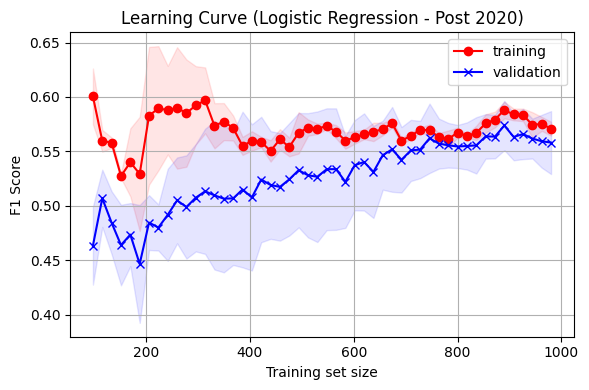

In [409]:
# 6. Feature importance
coefficients_pre2020 = pd.DataFrame({
    'Feature': diff_features,
    'Coefficient': model_pre2020.coef_[0]
}).sort_values(by='Coefficient', key=abs, ascending=False)

print(f"Accuracy: {accuracy_pre2020:.3f}")
print(f"F1 Score: {f1_pre2020:.3f}")
print("\nClassification Report:\n", report_pre2020)
print("\nTop 10 Most Influential Features:")
print(coefficients_pre2020.head(10))  # Top 10 features
print("\n10 Least Influential Features:")
print(coefficients_pre2020.tail(10))

# 8. Learning Curve
train_sizes, train_scores, val_scores = learning_curve(
    estimator=LogisticRegression(max_iter=1000),
    X=X,
    y=y,
    train_sizes=np.linspace(0.1, 1.0, 50),
    cv=5,
    scoring=make_scorer(f1_score),
    n_jobs=-1,
    random_state=42
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# 9. Plotting
plt.figure(figsize=(6, 4))
plt.plot(train_sizes, train_mean, 'r-', label='training', marker='o')
plt.plot(train_sizes, val_mean, 'b-', label='validation', marker='x')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='red', alpha=0.1)
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, color='blue', alpha=0.1)
plt.xlabel('Training set size')
plt.ylabel('F1 Score')
plt.title('Learning Curve (Logistic Regression - Pre 2020)')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()

In [205]:
# now for post 2020

Accuracy: 0.728
F1 Score: 0.645

Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.83      0.78       207
           1       0.72      0.59      0.64       150

    accuracy                           0.73       357
   macro avg       0.73      0.71      0.71       357
weighted avg       0.73      0.73      0.72       357


Top 10 Most Influential Features:
                           Feature  Coefficient
14                        Diff RPI     0.668523
13         Diff Turnovers per Game    -0.406711
12               Diff Shot Percent     0.239592
10     Diff Goals Allowed per Game    -0.186310
3             Diff Faceoff Percent     0.158288
9              Diff Saves per Game    -0.142142
4        Diff Groundballs per Game     0.111801
11             Diff Average Margin     0.108742
7      Diff Opponent Clear Percent    -0.104731
1   Diff Caused Turnovers per Game     0.095641

10 Least Influential Features:
                     

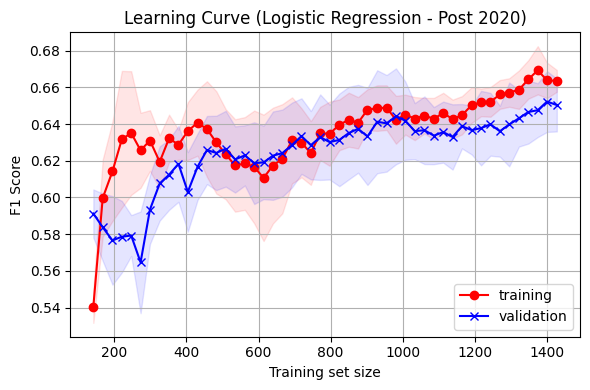

In [410]:
# 1. Define target variable
df_post2020['Win'] = (df_post2020['Winner'] == df_post2020['Team 1']).astype(int)

# 2. Select only differential features
all_diff_features = [col for col in df_post2020.columns if col.startswith("Diff ") and df_post2020[col].notna().all()]
diff_features = [col for col in all_diff_features if 'Games Played' not in col]

# 3. Create X and y
X = df_post2020[diff_features].copy()
y = df_post2020['Win']

# 4. Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 5. Train logistic regression
model_post2020 = LogisticRegression(max_iter=1000)
model_post2020.fit(X_train, y_train)

# 6. Evaluate model
y_pred = model_post2020.predict(X_test)
accuracy_post2020 = accuracy_score(y_test, y_pred)
f1_post2020 = f1_score(y_test, y_pred)
report_post2020 = classification_report(y_test, y_pred)

# 7. Feature importance
coefficients_post2020 = pd.DataFrame({
    'Feature': diff_features,
    'Coefficient': model_post2020.coef_[0]
}).sort_values(by='Coefficient', key=abs, ascending=False)

print(f"Accuracy: {accuracy_post2020:.3f}")
print(f"F1 Score: {f1_post2020:.3f}")
print("\nClassification Report:\n", report_post2020)
print("\nTop 10 Most Influential Features:")
print(coefficients_post2020.head(10))  # Top 10 features
print("\n10 Least Influential Features:")
print(coefficients_post2020.tail(10))

# 8. Learning Curve
train_sizes, train_scores, val_scores = learning_curve(
    estimator=LogisticRegression(max_iter=1000),
    X=X,
    y=y,
    train_sizes=np.linspace(0.1, 1.0, 50),
    cv=5,
    scoring=make_scorer(f1_score),
    n_jobs=-1,
    random_state=42
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# 9. Plotting
plt.figure(figsize=(6, 4))
plt.plot(train_sizes, train_mean, 'r-', label='training', marker='o')
plt.plot(train_sizes, val_mean, 'b-', label='validation', marker='x')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='red', alpha=0.1)
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, color='blue', alpha=0.1)
plt.xlabel('Training set size')
plt.ylabel('F1 Score')
plt.title('Learning Curve (Logistic Regression - Post 2020)')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()


Both of these actually got us solid results. By looking at the learning curves, we can see that both of these did a pretty good job of neither overfitting or underfitting. The pre 2020 data has some overfitting, and we can try and reduce the complexity to fix this. We can also see which statistics have the highest impact on a team's success.

## Regularization

In this next section, we add regularization to see if it improves performance, and to give us more insight on which statistics are important (and not important) to a team's success.

### Ridge Regularization (L2)

Ridge Regularization will reduce ALL of the weights of the features.

In [411]:
# imports
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd

Accuracy: 0.702
F1 Score: 0.547

Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.85      0.78       150
           1       0.67      0.46      0.55        95

    accuracy                           0.70       245
   macro avg       0.69      0.66      0.66       245
weighted avg       0.70      0.70      0.69       245


Top 10 Most Influential Features:
                           Feature  Coefficient
13                        Diff RPI     0.346797
12         Diff Turnovers per Game    -0.247800
0            Diff Assists per Game     0.238396
3             Diff Faceoff Percent     0.229259
8              Diff Saves per Game    -0.209474
11               Diff Shot Percent     0.189601
1   Diff Caused Turnovers per Game     0.171493
4        Diff Groundballs per Game    -0.171006
10             Diff Average Margin     0.100734
2            Diff Clearing Percent     0.090039

10 Least Influential Features:
                     

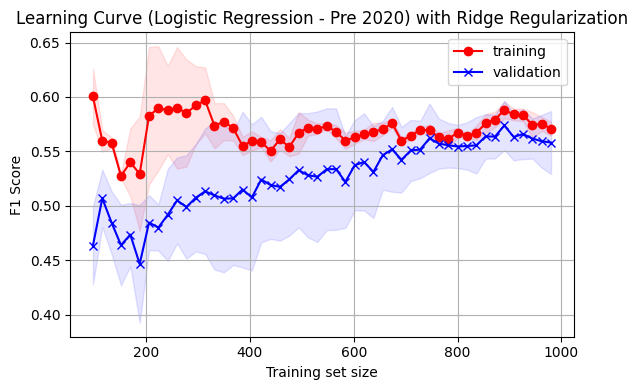

In [413]:
#pre 2020

# Select only differential features
all_diff_features = [col for col in df_pre2020.columns if col.startswith("Diff ") and df_pre2020[col].notna().all()]
diff_features = [col for col in all_diff_features if 'Games Played' not in col]

# Create X and y
X = df_pre2020[diff_features].copy()
y = df_pre2020['Win']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train logistic regression with L2 regularization -- ridge
model_pre2020 = LogisticRegression(penalty='l2', solver='liblinear', C=0.1)
model_pre2020.fit(X_train, y_train)

# Evaluate model
y_pred = model_pre2020.predict(X_test)
accuracy_pre2020 = accuracy_score(y_test, y_pred)
f1_pre2020 = f1_score(y_test, y_pred)
report_pre2020 = classification_report(y_test, y_pred)

# Feature importance
coefficients_pre2020 = pd.DataFrame({
    'Feature': diff_features,
    'Coefficient': model_pre2020.coef_[0]
}).sort_values(by='Coefficient', key=abs, ascending=False)

# Output
print(f"Accuracy: {accuracy_pre2020:.3f}")
print(f"F1 Score: {f1_pre2020:.3f}")
print("\nClassification Report:\n", report_pre2020)
print("\nTop 10 Most Influential Features:")
print(coefficients_pre2020.head(10))
print("\n10 Least Influential Features:")
print(coefficients_pre2020.tail(10))

# 8. Learning Curve
train_sizes, train_scores, val_scores = learning_curve(
    estimator=LogisticRegression(max_iter=1000),
    X=X,
    y=y,
    train_sizes=np.linspace(0.1, 1.0, 50),
    cv=5,
    scoring=make_scorer(f1_score),
    n_jobs=-1,
    random_state=42
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# 9. Plotting
plt.figure(figsize=(6, 4))
plt.plot(train_sizes, train_mean, 'r-', label='training', marker='o')
plt.plot(train_sizes, val_mean, 'b-', label='validation', marker='x')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='red', alpha=0.1)
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, color='blue', alpha=0.1)
plt.xlabel('Training set size')
plt.ylabel('F1 Score')
plt.title('Learning Curve (Logistic Regression - Pre 2020) with Ridge Regularization')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()

Accuracy: 0.739
F1 Score: 0.674

Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.81      0.78       207
           1       0.71      0.64      0.67       150

    accuracy                           0.74       357
   macro avg       0.73      0.73      0.73       357
weighted avg       0.74      0.74      0.74       357


Top 10 Most Influential Features:
                        Feature  Coefficient
14                     Diff RPI     0.429372
13      Diff Turnovers per Game    -0.248823
11          Diff Average Margin     0.165638
10  Diff Goals Allowed per Game    -0.149978
12            Diff Shot Percent     0.133591
8           Diff Goals per Game     0.125964
9           Diff Saves per Game    -0.104989
3          Diff Faceoff Percent     0.098159
4     Diff Groundballs per Game     0.098050
0         Diff Assists per Game     0.088318

10 Least Influential Features:
                          Feature  Coefficient
8      

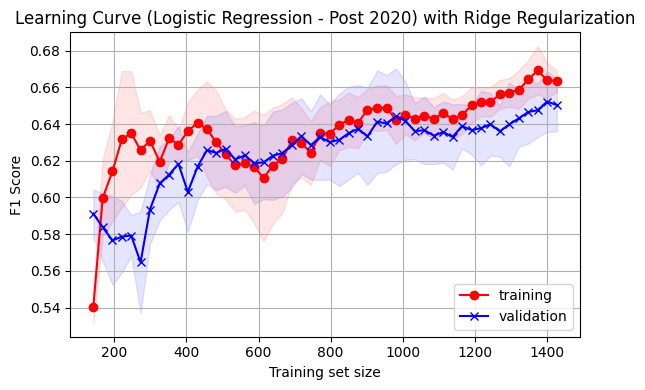

In [414]:
# post 2020

# Define target variable
df_post2020['Win'] = (df_post2020['Winner'] == df_post2020['Team 1']).astype(int)

# Select only differential features
all_diff_features = [col for col in df_post2020.columns if col.startswith("Diff ") and df_post2020[col].notna().all()]
diff_features = [col for col in all_diff_features if 'Games Played' not in col]

# Create X and y
X = df_post2020[diff_features].copy()
y = df_post2020['Win']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train logistic regression with L2 regularization
model_post2020 = LogisticRegression(penalty='l2', solver='liblinear', C=0.01)
model_post2020.fit(X_train, y_train)

# Evaluate model
y_pred = model_post2020.predict(X_test)
accuracy_post2020 = accuracy_score(y_test, y_pred)
f1_post2020 = f1_score(y_test, y_pred)
report_post2020 = classification_report(y_test, y_pred)

# Feature importance
coefficients_post2020 = pd.DataFrame({
    'Feature': diff_features,
    'Coefficient': model_post2020.coef_[0]
}).sort_values(by='Coefficient', key=abs, ascending=False)

# Output
print(f"Accuracy: {accuracy_post2020:.3f}")
print(f"F1 Score: {f1_post2020:.3f}")
print("\nClassification Report:\n", report_post2020)
print("\nTop 10 Most Influential Features:")
print(coefficients_post2020.head(10))
print("\n10 Least Influential Features:")
print(coefficients_post2020.tail(10))


# 8. Learning Curve
train_sizes, train_scores, val_scores = learning_curve(
    estimator=LogisticRegression(max_iter=1000),
    X=X,
    y=y,
    train_sizes=np.linspace(0.1, 1.0, 50),
    cv=5,
    scoring=make_scorer(f1_score),
    n_jobs=-1,
    random_state=42
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# 9. Plotting
plt.figure(figsize=(6, 4))
plt.plot(train_sizes, train_mean, 'r-', label='training', marker='o')
plt.plot(train_sizes, val_mean, 'b-', label='validation', marker='x')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='red', alpha=0.1)
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, color='blue', alpha=0.1)
plt.xlabel('Training set size')
plt.ylabel('F1 Score')
plt.title('Learning Curve (Logistic Regression - Post 2020) with Ridge Regularization')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()

### Lasso Regularization (L1)

Accuracy: 0.690
F1 Score: 0.531

Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.84      0.77       150
           1       0.64      0.45      0.53        95

    accuracy                           0.69       245
   macro avg       0.67      0.65      0.65       245
weighted avg       0.68      0.69      0.68       245


Top 10 Most Influential Features:
                           Feature  Coefficient
13                        Diff RPI     0.333459
10             Diff Average Margin     0.265032
12         Diff Turnovers per Game    -0.198406
8              Diff Saves per Game    -0.188504
0            Diff Assists per Game     0.149784
11               Diff Shot Percent     0.076956
3             Diff Faceoff Percent     0.064005
2            Diff Clearing Percent     0.051834
1   Diff Caused Turnovers per Game     0.033673
9      Diff Goals Allowed per Game    -0.013965

10 Least Influential Features:
                     

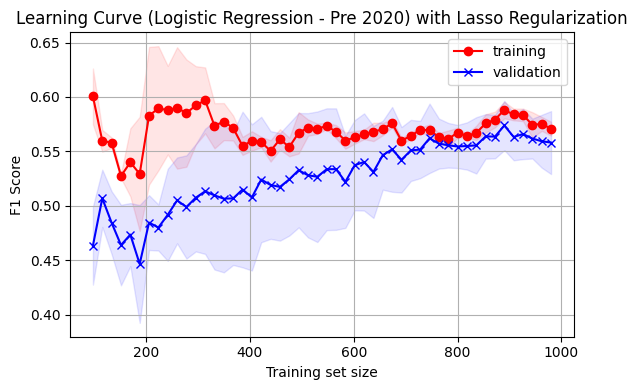

In [416]:
# pre 2020

# Select only differential features
all_diff_features = [col for col in df_pre2020.columns if col.startswith("Diff ") and df_pre2020[col].notna().all()]
diff_features = [col for col in all_diff_features if 'Games Played' not in col]

# Create X and y
X = df_pre2020[diff_features].copy()
y = df_pre2020['Win']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train logistic regression with L2 regularization -- ridge
model_pre2020 = LogisticRegression(penalty='l1', solver='liblinear', C=0.1)
model_pre2020.fit(X_train, y_train)

# Evaluate model
y_pred = model_pre2020.predict(X_test)
accuracy_pre2020 = accuracy_score(y_test, y_pred)
f1_pre2020 = f1_score(y_test, y_pred)
report_pre2020 = classification_report(y_test, y_pred)

# Feature importance
coefficients_pre2020 = pd.DataFrame({
    'Feature': diff_features,
    'Coefficient': model_pre2020.coef_[0]
}).sort_values(by='Coefficient', key=abs, ascending=False)

# Output
print(f"Accuracy: {accuracy_pre2020:.3f}")
print(f"F1 Score: {f1_pre2020:.3f}")
print("\nClassification Report:\n", report_pre2020)
print("\nTop 10 Most Influential Features:")
print(coefficients_pre2020.head(10))
print("\n10 Least Influential Features:")
print(coefficients_pre2020.tail(10))

# 8. Learning Curve
train_sizes, train_scores, val_scores = learning_curve(
    estimator=LogisticRegression(max_iter=1000),
    X=X,
    y=y,
    train_sizes=np.linspace(0.1, 1.0, 50),
    cv=5,
    scoring=make_scorer(f1_score),
    n_jobs=-1,
    random_state=42
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# 9. Plotting
plt.figure(figsize=(6, 4))
plt.plot(train_sizes, train_mean, 'r-', label='training', marker='o')
plt.plot(train_sizes, val_mean, 'b-', label='validation', marker='x')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='red', alpha=0.1)
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, color='blue', alpha=0.1)
plt.xlabel('Training set size')
plt.ylabel('F1 Score')
plt.title('Learning Curve (Logistic Regression - Pre 2020) with Lasso Regularization')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()

Accuracy: 0.703
F1 Score: 0.665

Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.71      0.73       207
           1       0.63      0.70      0.66       150

    accuracy                           0.70       357
   macro avg       0.70      0.70      0.70       357
weighted avg       0.71      0.70      0.70       357


Top 10 Most Influential Features:
                           Feature  Coefficient
11             Diff Average Margin     0.148887
13         Diff Turnovers per Game    -0.083790
4        Diff Groundballs per Game     0.036364
0            Diff Assists per Game     0.000000
3             Diff Faceoff Percent     0.000000
5    Diff Man Down Defense Percent     0.000000
2            Diff Clearing Percent     0.000000
1   Diff Caused Turnovers per Game     0.000000
7      Diff Opponent Clear Percent     0.000000
6      Diff Man Up Offense Percent     0.000000

10 Least Influential Features:
                     

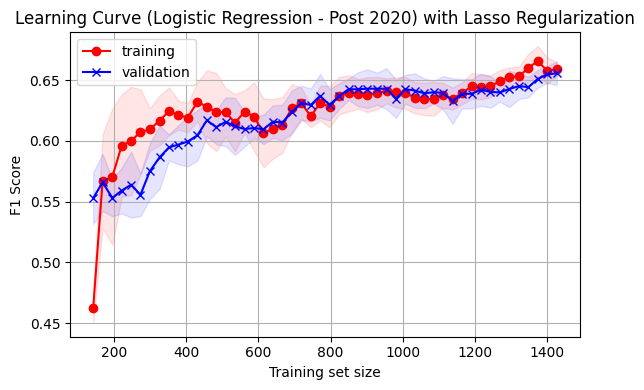

In [553]:
# post 2020

# Define target variable
df_post2020['Win'] = (df_post2020['Winner'] == df_post2020['Team 1']).astype(int)

# Select only differential features
all_diff_features = [col for col in df_post2020.columns if col.startswith("Diff ") and df_post2020[col].notna().all()]
diff_features = [col for col in all_diff_features if 'Games Played' not in col]

# Create X and y
X = df_post2020[diff_features].copy()
y = df_post2020['Win']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train logistic regression with L2 regularization
model_post2020 = LogisticRegression(penalty='l1', solver='liblinear', C=0.01)
model_post2020.fit(X_train, y_train)

# Evaluate model
y_pred = model_post2020.predict(X_test)
accuracy_post2020 = accuracy_score(y_test, y_pred)
f1_post2020 = f1_score(y_test, y_pred)
report_post2020 = classification_report(y_test, y_pred)

# Feature importance
coefficients_post2020 = pd.DataFrame({
    'Feature': diff_features,
    'Coefficient': model_post2020.coef_[0]
}).sort_values(by='Coefficient', key=abs, ascending=False)

# Output
print(f"Accuracy: {accuracy_post2020:.3f}")
print(f"F1 Score: {f1_post2020:.3f}")
print("\nClassification Report:\n", report_post2020)
print("\nTop 10 Most Influential Features:")
print(coefficients_post2020.head(10))
print("\n10 Least Influential Features:")
print(coefficients_post2020.tail(10))

# 8. Learning Curve
train_sizes, train_scores, val_scores = learning_curve(
    estimator=LogisticRegression(max_iter=1000),
    X=X,
    y=y,
    train_sizes=np.linspace(0.1, 1.0, 50),
    cv=5,
    scoring=make_scorer(f1_score),
    n_jobs=-1,
    random_state=42
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# 9. Plotting
plt.figure(figsize=(6, 4))
plt.plot(train_sizes, train_mean, 'r-', label='training', marker='o')
plt.plot(train_sizes, val_mean, 'b-', label='validation', marker='x')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='red', alpha=0.1)
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, color='blue', alpha=0.1)
plt.xlabel('Training set size')
plt.ylabel('F1 Score')
plt.title('Learning Curve (Logistic Regression - Post 2020) with Lasso Regularization')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()

Both regularizations helped the post 2020 data the most, and did not have much of an effect on the pre 2020 data.

# Random Forest

I'm curious to see how a random forest will perform on the same exact data set.

## Pre-processing the Data

In [419]:
# imports

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

In [420]:
# Load in our dataset
# Define the path to your CSV file
file_path = "/content/drive/MyDrive/Colab Notebooks/Final Project Real Folder/Final Data/ncaa_lacrosse_with_RPI.csv"

# Load the data
df = pd.read_csv(file_path)

print(df.shape)

(4160, 37)


In [421]:
# Ensure Date is a datetime object
df['Date'] = pd.to_datetime(df['Date'])

# Sort by date to ensure correct game order
df = df.sort_values(by='Date').reset_index(drop=True)

# Function to count games per team up to each date
def add_game_counts(df):
    team_game_counts = {}

    game_counts = []

    for i, row in df.iterrows():
        year = row['Year']
        team1 = row['Team 1']
        team2 = row['Team 2']
        date = row['Date']

        # Create keys based on year and team
        key1 = (year, team1)
        key2 = (year, team2)

        # Get current game count
        count1 = team_game_counts.get(key1, 0)
        count2 = team_game_counts.get(key2, 0)

        game_counts.append((count1, count2))

        # Increment game counts AFTER the game
        team_game_counts[key1] = count1 + 1
        team_game_counts[key2] = count2 + 1

    df['Team 1 Games Played'] = [c[0] for c in game_counts]
    df['Team 2 Games Played'] = [c[1] for c in game_counts]

    return df

# Add game counts
df = add_game_counts(df)

# Filter: keep only games where both teams have played at least 2 games before this one
df = df[(df['Team 1 Games Played'] >= 2) & (df['Team 2 Games Played'] >= 2)]

# Preview cleaned data
#df.head()

print(df.shape)


(3420, 39)


In [422]:
# Remove games with a 0-0 score (invalid data)
df = df[~((df['Score 1'] == 0) & (df['Score 2'] == 0))]

print(df.shape)

(3416, 39)


In [423]:
# List of Opponent Clear Percent columns to exclude from NaN filtering
excluded_columns = ['Team 1 Opponent Clear Percent', 'Team 2 Opponent Clear Percent']

# Columns to check for NaNs (all except excluded ones)
columns_to_check = [col for col in df.columns if col not in excluded_columns]

# Drop rows with NaNs in any of those columns
df = df.dropna(subset=columns_to_check).reset_index(drop=True)

# Preview cleaned data
#df.head()

print(df.shape)

(3009, 39)


In [424]:
# Split the dataset by year so I can do the same thing to opponent clear percentage AFTER 2020
df_pre2020 = df[(df['Year'] >= 2015) & (df['Year'] <= 2019)].copy()
df_post2020 = df[(df['Year'] >= 2020) & (df['Year'] <= 2024)].copy()


# Check sizes
print("Pre-2020 dataset shape:", df_pre2020.shape)
print("2020+ dataset shape:", df_post2020.shape)



Pre-2020 dataset shape: (1225, 39)
2020+ dataset shape: (1784, 39)


In [425]:
# drop NaN in opponent clear percentage for post 2020
df_post2020 = df_post2020.dropna(subset=['Team 1 Opponent Clear Percent', 'Team 2 Opponent Clear Percent']).reset_index(drop=True)

In [426]:
print("Pre-2020 dataset shape:", df_pre2020.shape)
print("2020+ dataset shape:", df_post2020.shape)

Pre-2020 dataset shape: (1225, 39)
2020+ dataset shape: (1784, 39)


In [427]:
# Identify matching statistic pairs
team1_prefix = "Team 1 "
team2_prefix = "Team 2 "

# Collect column pairs for which both Team 1 and Team 2 have values
stat_columns = []
for col in df_pre2020.columns:
    if col.startswith(team1_prefix):
        team1_stat = col
        team2_stat = team2_prefix + col[len(team1_prefix):]
        if team2_stat in df_pre2020.columns:
            stat_columns.append((team1_stat, team2_stat))

# Function to compute differential features
def add_differential_features(df, stat_columns):
    for t1_col, t2_col in stat_columns:
        diff_col = "Diff " + t1_col[len(team1_prefix):]
        df[diff_col] = df[t1_col] - df[t2_col]
    return df

# Apply to both datasets
df_pre2020 = add_differential_features(df_pre2020, stat_columns)
df_post2020 = add_differential_features(df_post2020, stat_columns)

# Preview updated data
df_pre2020[[col for col in df_pre2020.columns if col.startswith("Diff")]].head()


,Diff Assists per Game,Diff Caused Turnovers per Game,Diff Clearing Percent,Diff Faceoff Percent,Diff Groundballs per Game,Diff Man Down Defense Percent,Diff Man Up Offense Percent,Diff Opponent Clear Percent,Diff Goals per Game,Diff Saves per Game,Diff Goals Allowed per Game,Diff Average Margin,Diff Shot Percent,Diff Turnovers per Game,Diff RPI,Diff Games Played
0,1.50,-0.50,-0.027,-0.052,3.50,-0.130,-0.167,NaN,2.00,1.5,4.00,-2.00,0.007,-4.00,0.00000,0
1,-6.00,2.00,-0.033,-0.189,-10.00,0.047,-0.714,NaN,-8.50,2.5,-3.50,-5.00,-0.194,-0.50,-0.25000,0
2,0.00,2.50,0.041,-0.215,-10.00,-0.127,0.178,NaN,-1.50,-2.0,-3.50,2.00,0.002,-9.50,0.25000,0
3,4.33,0.67,-0.045,-0.215,-6.34,-0.118,0.092,NaN,5.33,-1.0,4.67,0.67,0.257,0.67,0.18750,-1
4,-3.33,-4.33,0.031,0.057,-8.00,-0.378,0.083,NaN,-3.67,2.5,0.17,-3.83,-0.060,6.50,0.02778,-1


In [428]:
def normalize_differential_features_only(df):
    # Identify differential columns
    diff_cols = [col for col in df.columns if col.startswith("Diff ") and df[col].notna().all()]

    # Standardize only those columns
    scaler = StandardScaler()
    df[diff_cols] = scaler.fit_transform(df[diff_cols])

    return df

# Apply normalization to both datasets
df_pre2020 = normalize_differential_features_only(df_pre2020)
df_post2020 = normalize_differential_features_only(df_post2020)

## Training the Random Forest

In [429]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report
import pandas as pd

def run_rf_with_report(df, label, drop_columns=None):
    # 1. Create binary target
    df['Team 1 Win'] = (df['Winner'].str.lower() == df['Team 1'].str.lower()).astype(int)

    # 2. Drop unwanted columns
    if drop_columns:
        df = df.drop(columns=drop_columns, errors='ignore')

    # 3. Use only relevant differential features
    diff_features = [col for col in df.columns if col.startswith('Diff') and 'Games Played' not in col]

    # 4. Drop rows with missing values
    df_clean = df.dropna(subset=diff_features)
    X = df_clean[diff_features]
    y = df_clean['Team 1 Win']

    # 5. Train/test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # 6. Train Random Forest
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)

    # 7. Evaluate
    y_pred = rf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)

    # 8. Feature importances
    importances = rf.feature_importances_
    feature_importance_df = pd.DataFrame({
        'Feature': diff_features,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)

    # 9. Output report
    print(f"{label} Accuracy: {accuracy:.3f}")
    print(f"{label} F1 Score: {f1:.3f}\n")
    print("Classification Report:\n", report)

    print("Top 10 Most Influential Features:")
    print(feature_importance_df.head(10).to_string(index=False))

    print("\n10 Least Influential Features:")
    print(feature_importance_df.tail(10).to_string(index=False))


In [430]:
run_rf_with_report(df_pre2020, "Pre-2020", drop_columns=['Diff Opponent Clear Percent'])

Pre-2020 Accuracy: 0.678
Pre-2020 F1 Score: 0.554

Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.78      0.75       150
           1       0.60      0.52      0.55        95

    accuracy                           0.68       245
   macro avg       0.66      0.65      0.65       245
weighted avg       0.67      0.68      0.67       245

Top 10 Most Influential Features:
                    Feature  Importance
                   Diff RPI    0.107262
        Diff Average Margin    0.097389
      Diff Assists per Game    0.075657
    Diff Turnovers per Game    0.073301
        Diff Goals per Game    0.070901
          Diff Shot Percent    0.070652
Diff Goals Allowed per Game    0.067724
      Diff Clearing Percent    0.067664
       Diff Faceoff Percent    0.065186
Diff Man Up Offense Percent    0.063227

10 Least Influential Features:
                       Feature  Importance
           Diff Goals per Game    0.070901
      

In [431]:
run_rf_with_report(df_post2020, "Post-2020")

Post-2020 Accuracy: 0.723
Post-2020 F1 Score: 0.635

Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.83      0.78       207
           1       0.71      0.57      0.63       150

    accuracy                           0.72       357
   macro avg       0.72      0.70      0.71       357
weighted avg       0.72      0.72      0.72       357

Top 10 Most Influential Features:
                    Feature  Importance
                   Diff RPI    0.140309
        Diff Average Margin    0.104144
        Diff Goals per Game    0.078386
    Diff Turnovers per Game    0.072261
  Diff Groundballs per Game    0.063376
      Diff Assists per Game    0.062385
Diff Goals Allowed per Game    0.062381
          Diff Shot Percent    0.056336
       Diff Faceoff Percent    0.054513
      Diff Clearing Percent    0.053506

10 Least Influential Features:
                       Feature  Importance
         Diff Assists per Game    0.062385
   D

# XGBoost

Let's do a XGBoost to see if it does better.

## Pre-processing the Data

In [432]:
# imports

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

In [433]:
# Load in our dataset
# Define the path to your CSV file
file_path = "/content/drive/MyDrive/Colab Notebooks/Final Project Real Folder/Final Data/ncaa_lacrosse_with_RPI.csv"

# Load the data
df = pd.read_csv(file_path)

print(df.shape)

(4160, 37)


In [434]:
# Ensure Date is a datetime object
df['Date'] = pd.to_datetime(df['Date'])

# Sort by date to ensure correct game order
df = df.sort_values(by='Date').reset_index(drop=True)

# Function to count games per team up to each date
def add_game_counts(df):
    team_game_counts = {}

    game_counts = []

    for i, row in df.iterrows():
        year = row['Year']
        team1 = row['Team 1']
        team2 = row['Team 2']
        date = row['Date']

        # Create keys based on year and team
        key1 = (year, team1)
        key2 = (year, team2)

        # Get current game count
        count1 = team_game_counts.get(key1, 0)
        count2 = team_game_counts.get(key2, 0)

        game_counts.append((count1, count2))

        # Increment game counts AFTER the game
        team_game_counts[key1] = count1 + 1
        team_game_counts[key2] = count2 + 1

    df['Team 1 Games Played'] = [c[0] for c in game_counts]
    df['Team 2 Games Played'] = [c[1] for c in game_counts]

    return df

# Add game counts
df = add_game_counts(df)

# Filter: keep only games where both teams have played at least 2 games before this one
df = df[(df['Team 1 Games Played'] >= 2) & (df['Team 2 Games Played'] >= 2)]

# Preview cleaned data
#df.head()

print(df.shape)


(3420, 39)


In [435]:
# Remove games with a 0-0 score (invalid data)
df = df[~((df['Score 1'] == 0) & (df['Score 2'] == 0))]

print(df.shape)

(3416, 39)


In [436]:
# List of Opponent Clear Percent columns to exclude from NaN filtering
excluded_columns = ['Team 1 Opponent Clear Percent', 'Team 2 Opponent Clear Percent']

# Columns to check for NaNs (all except excluded ones)
columns_to_check = [col for col in df.columns if col not in excluded_columns]

# Drop rows with NaNs in any of those columns
df = df.dropna(subset=columns_to_check).reset_index(drop=True)

# Preview cleaned data
#df.head()

print(df.shape)

(3009, 39)


In [437]:
# Split the dataset by year so I can do the same thing to opponent clear percentage AFTER 2020
df_pre2020 = df[(df['Year'] >= 2015) & (df['Year'] <= 2019)].copy()
df_post2020 = df[(df['Year'] >= 2020) & (df['Year'] <= 2024)].copy()


# Check sizes
print("Pre-2020 dataset shape:", df_pre2020.shape)
print("2020+ dataset shape:", df_post2020.shape)



Pre-2020 dataset shape: (1225, 39)
2020+ dataset shape: (1784, 39)


In [438]:
# drop NaN in opponent clear percentage for post 2020
df_post2020 = df_post2020.dropna(subset=['Team 1 Opponent Clear Percent', 'Team 2 Opponent Clear Percent']).reset_index(drop=True)

In [439]:
print("Pre-2020 dataset shape:", df_pre2020.shape)
print("2020+ dataset shape:", df_post2020.shape)

Pre-2020 dataset shape: (1225, 39)
2020+ dataset shape: (1784, 39)


In [440]:
# Identify matching statistic pairs
team1_prefix = "Team 1 "
team2_prefix = "Team 2 "

# Collect column pairs for which both Team 1 and Team 2 have values
stat_columns = []
for col in df_pre2020.columns:
    if col.startswith(team1_prefix):
        team1_stat = col
        team2_stat = team2_prefix + col[len(team1_prefix):]
        if team2_stat in df_pre2020.columns:
            stat_columns.append((team1_stat, team2_stat))

# Function to compute differential features
def add_differential_features(df, stat_columns):
    for t1_col, t2_col in stat_columns:
        diff_col = "Diff " + t1_col[len(team1_prefix):]
        df[diff_col] = df[t1_col] - df[t2_col]
    return df

# Apply to both datasets
df_pre2020 = add_differential_features(df_pre2020, stat_columns)
df_post2020 = add_differential_features(df_post2020, stat_columns)

# Preview updated data
df_pre2020[[col for col in df_pre2020.columns if col.startswith("Diff")]].head()


,Diff Assists per Game,Diff Caused Turnovers per Game,Diff Clearing Percent,Diff Faceoff Percent,Diff Groundballs per Game,Diff Man Down Defense Percent,Diff Man Up Offense Percent,Diff Opponent Clear Percent,Diff Goals per Game,Diff Saves per Game,Diff Goals Allowed per Game,Diff Average Margin,Diff Shot Percent,Diff Turnovers per Game,Diff RPI,Diff Games Played
0,1.50,-0.50,-0.027,-0.052,3.50,-0.130,-0.167,NaN,2.00,1.5,4.00,-2.00,0.007,-4.00,0.00000,0
1,-6.00,2.00,-0.033,-0.189,-10.00,0.047,-0.714,NaN,-8.50,2.5,-3.50,-5.00,-0.194,-0.50,-0.25000,0
2,0.00,2.50,0.041,-0.215,-10.00,-0.127,0.178,NaN,-1.50,-2.0,-3.50,2.00,0.002,-9.50,0.25000,0
3,4.33,0.67,-0.045,-0.215,-6.34,-0.118,0.092,NaN,5.33,-1.0,4.67,0.67,0.257,0.67,0.18750,-1
4,-3.33,-4.33,0.031,0.057,-8.00,-0.378,0.083,NaN,-3.67,2.5,0.17,-3.83,-0.060,6.50,0.02778,-1


In [441]:
def normalize_differential_features_only(df):
    # Identify differential columns
    diff_cols = [col for col in df.columns if col.startswith("Diff ") and df[col].notna().all()]

    # Standardize only those columns
    scaler = StandardScaler()
    df[diff_cols] = scaler.fit_transform(df[diff_cols])

    return df

# Apply normalization to both datasets
df_pre2020 = normalize_differential_features_only(df_pre2020)
df_post2020 = normalize_differential_features_only(df_post2020)

## Training the XGBoost Model.

This training is similar to the previous ones, except there are different metrics for trees, all of which I print in a table. This is important to understand what each of these do.

In [442]:
# --- Imports ---
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

In [443]:
def run_xgb_with_report(df, label, drop_columns=None):
    # 1. Create binary target
    df['Team 1 Win'] = (df['Winner'].str.lower() == df['Team 1'].str.lower()).astype(int)

    # 2. Drop unwanted columns
    if drop_columns:
        df = df.drop(columns=drop_columns, errors='ignore')

    # 3. Select features
    diff_features = [col for col in df.columns if col.startswith('Diff') and 'Games Played' not in col]

    # 4. Drop rows with missing values
    df_clean = df.dropna(subset=diff_features)
    X = df_clean[diff_features]
    y = df_clean['Team 1 Win']

    # 5. Train/test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # 6. Train XGBoost model
    model = xgb.XGBClassifier(n_estimators=100, eval_metric='logloss', random_state=42)
    model.fit(X_train, y_train)

    # 7. Evaluate
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)

    # 8. Feature importance
    importance_dict = model.get_booster().get_score(importance_type='gain')
    importance_df = pd.DataFrame({
        'Feature': list(importance_dict.keys()),
        'Importance': list(importance_dict.values())
    }).sort_values(by='Importance', ascending=False)

    # Fill in any missing features (e.g., zero importance)
    all_features_df = pd.DataFrame({'Feature': diff_features})
    importance_df = all_features_df.merge(importance_df, on='Feature', how='left').fillna(0)

    # 9. Output

    print(f"{label} Accuracy (XGBoost): {accuracy:.3f}")
    print(f"{label} F1 Score: {f1:.3f}\n")
    print("Classification Report:\n", report)

    '''
    print("Top 10 Most Influential Features:")
    print(importance_df.head(10).to_string(index=False))

    print("\n10 Least Influential Features:")
    print(importance_df.tail(10).to_string(index=False))
    '''

    # 10. Compare multiple importance types
    importance_types = ['weight', 'gain', 'cover', 'total_gain', 'total_cover']
    importance_dicts = {}

    # Collect importance for each type
    for imp_type in importance_types:
        importance_dicts[imp_type] = model.get_booster().get_score(importance_type=imp_type)

    # Build DataFrame
    importance_df = pd.DataFrame({'Feature': diff_features})

    for imp_type in importance_types:
        imp_data = pd.Series(importance_dicts[imp_type])
        importance_df[imp_type] = importance_df['Feature'].map(imp_data).fillna(0)

    # Sort by gain (or any other metric you prefer)
    importance_df = importance_df.sort_values(by='gain', ascending=False)

    # Print the table
    print("\nFull Feature Importance Comparison:")
    print(importance_df.head(15).to_string(index=False))

In [444]:
run_xgb_with_report(df_pre2020, "Pre-2020", drop_columns=['Diff Opponent Clear Percent'])

Pre-2020 Accuracy (XGBoost): 0.665
Pre-2020 F1 Score: 0.534

Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.77      0.74       150
           1       0.58      0.49      0.53        95

    accuracy                           0.67       245
   macro avg       0.64      0.63      0.64       245
weighted avg       0.66      0.67      0.66       245


Full Feature Importance Comparison:
                       Feature  weight     gain     cover  total_gain  total_cover
           Diff Average Margin   143.0 1.808430 27.804916  258.605560  3976.103027
                      Diff RPI   169.0 1.771893 26.504749  299.449890  4479.302734
           Diff Saves per Game   173.0 1.224151 17.288784  211.778137  2990.959473
             Diff Shot Percent   146.0 1.140151 18.480495  166.461975  2698.152344
         Diff Assists per Game   157.0 1.048814 24.172995  164.663864  3795.160156
         Diff Clearing Percent   159.0 1.009921 18.72

In [445]:
run_xgb_with_report(df_post2020, "Post-2020")

Post-2020 Accuracy (XGBoost): 0.700
Post-2020 F1 Score: 0.640

Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.75      0.74       207
           1       0.65      0.63      0.64       150

    accuracy                           0.70       357
   macro avg       0.69      0.69      0.69       357
weighted avg       0.70      0.70      0.70       357


Full Feature Importance Comparison:
                       Feature  weight     gain     cover  total_gain  total_cover
                      Diff RPI   194.0 3.966910 55.041168  769.580505 10677.986328
           Diff Average Margin   134.0 2.741928 45.636147  367.418335  6115.243652
           Diff Saves per Game   136.0 1.391977 19.478214  189.308868  2649.037109
       Diff Turnovers per Game   188.0 1.310219 24.904705  246.321198  4682.084473
          Diff Faceoff Percent   175.0 1.264033 36.175873  221.205795  6330.777832
   Diff Man Up Offense Percent   170.0 1.256809 28.

# Feature Engineering: Opposing Statistics

While the linear logistic regression performed pretty well and gave us valuable insight, I think there are more things to explore. In the first trainings of these models, we just compared how one team's statistics paired up to the other team's statsitcs, one by one. But in a real lacrosse game, offense doesn't play against offense. I want to see how these interact with each other. For example, I want to see the difference between Team 1's Offense and Team 2's Defense, and want to see if these have a bigger impact.

## Preprocessing the Data

We need to preprocess this data a little differently to get more of these statistics.

In [537]:
# imports
import pandas as pd

from sklearn.preprocessing import StandardScaler

In [538]:
# Load in our dataset
# Define the path to your CSV file
file_path = "/content/drive/MyDrive/Colab Notebooks/Final Project Real Folder/Final Data/ncaa_lacrosse_with_RPI.csv"

# Load the data
df = pd.read_csv(file_path)

print(df.shape)

(4160, 37)


In [539]:
# Ensure Date is a datetime object
df['Date'] = pd.to_datetime(df['Date'])

# Sort by date to ensure correct game order
df = df.sort_values(by='Date').reset_index(drop=True)

# Function to count games per team up to each date
def add_game_counts(df):
    team_game_counts = {}

    game_counts = []

    for i, row in df.iterrows():
        year = row['Year']
        team1 = row['Team 1']
        team2 = row['Team 2']
        date = row['Date']

        # Create keys based on year and team
        key1 = (year, team1)
        key2 = (year, team2)

        # Get current game count
        count1 = team_game_counts.get(key1, 0)
        count2 = team_game_counts.get(key2, 0)

        game_counts.append((count1, count2))

        # Increment game counts AFTER the game
        team_game_counts[key1] = count1 + 1
        team_game_counts[key2] = count2 + 1

    df['Team 1 Games Played'] = [c[0] for c in game_counts]
    df['Team 2 Games Played'] = [c[1] for c in game_counts]

    return df

# Add game counts
df = add_game_counts(df)

# Filter: keep only games where both teams have played at least 2 games before this one
df = df[(df['Team 1 Games Played'] >= 2) & (df['Team 2 Games Played'] >= 2)]

# Preview cleaned data
#df.head()

print(df.shape)


(3420, 39)


In [540]:
# Remove games with a 0-0 score (invalid data)
df = df[~((df['Score 1'] == 0) & (df['Score 2'] == 0))]

print(df.shape)

(3416, 39)


In [541]:
# List of Opponent Clear Percent columns to exclude from NaN filtering
excluded_columns = ['Team 1 Opponent Clear Percent', 'Team 2 Opponent Clear Percent']

# Columns to check for NaNs (all except excluded ones)
columns_to_check = [col for col in df.columns if col not in excluded_columns]

# Drop rows with NaNs in any of those columns
df = df.dropna(subset=columns_to_check).reset_index(drop=True)

# Preview cleaned data
#df.head()

print(df.shape)

(3009, 39)


The first thing we need to do is change the saves per game to a save percentage. This allows us to compare shot percentage to opposing team's save percentage. We can calculate this with saves per game/saves per game + goals allowed.

In [542]:
# add a goalie save pct (saves per game / [saves per game + goals allowed per game])

# Calculate goalie save percentage for Team 1
df['Team 1 Save Percent'] = df['Team 1 Saves per Game'] / (
    df['Team 1 Saves per Game'] + df['Team 1 Goals Allowed per Game']
)

# Calculate goalie save percentage for Team 2
df['Team 2 Save Percent'] = df['Team 2 Saves per Game'] / (
    df['Team 2 Saves per Game'] + df['Team 2 Goals Allowed per Game']
)

In [543]:
# Split the dataset by year so I can do the same thing to opponent clear percentage AFTER 2020
df_pre2020 = df[(df['Year'] >= 2015) & (df['Year'] <= 2019)].copy()
df_post2020 = df[(df['Year'] >= 2020) & (df['Year'] <= 2024)].copy()


# Check sizes
print("Pre-2020 dataset shape:", df_pre2020.shape)
print("2020+ dataset shape:", df_post2020.shape)



Pre-2020 dataset shape: (1225, 41)
2020+ dataset shape: (1784, 41)


In [544]:
# drop NaN in opponent clear percentage for post 2020
df_post2020 = df_post2020.dropna(subset=['Team 1 Opponent Clear Percent', 'Team 2 Opponent Clear Percent']).reset_index(drop=True)

In [545]:
print("Pre-2020 dataset shape:", df_pre2020.shape)
print("2020+ dataset shape:", df_post2020.shape)

Pre-2020 dataset shape: (1225, 41)
2020+ dataset shape: (1784, 41)


In [546]:
# let's add our differential features just in case
# Identify matching statistic pairs
team1_prefix = "Team 1 "
team2_prefix = "Team 2 "

# Collect column pairs for which both Team 1 and Team 2 have values
stat_columns = []
for col in df_pre2020.columns:
    if col.startswith(team1_prefix):
        team1_stat = col
        team2_stat = team2_prefix + col[len(team1_prefix):]
        if team2_stat in df_pre2020.columns:
            stat_columns.append((team1_stat, team2_stat))

# Function to compute differential features
def add_differential_features(df, stat_columns):
    for t1_col, t2_col in stat_columns:
        diff_col = "Diff " + t1_col[len(team1_prefix):]
        df[diff_col] = df[t1_col] - df[t2_col]
    return df

# Apply to both datasets
df_pre2020 = add_differential_features(df_pre2020, stat_columns)
df_post2020 = add_differential_features(df_post2020, stat_columns)

# Preview updated data
df_pre2020[[col for col in df_pre2020.columns if col.startswith("Diff")]].head()

,Diff Assists per Game,Diff Caused Turnovers per Game,Diff Clearing Percent,Diff Faceoff Percent,Diff Groundballs per Game,Diff Man Down Defense Percent,Diff Man Up Offense Percent,Diff Opponent Clear Percent,Diff Goals per Game,Diff Saves per Game,Diff Goals Allowed per Game,Diff Average Margin,Diff Shot Percent,Diff Turnovers per Game,Diff RPI,Diff Games Played,Diff Save Percent
0,1.50,-0.50,-0.027,-0.052,3.50,-0.130,-0.167,NaN,2.00,1.5,4.00,-2.00,0.007,-4.00,0.00000,0,-0.113306
1,-6.00,2.00,-0.033,-0.189,-10.00,0.047,-0.714,NaN,-8.50,2.5,-3.50,-5.00,-0.194,-0.50,-0.25000,0,0.157895
2,0.00,2.50,0.041,-0.215,-10.00,-0.127,0.178,NaN,-1.50,-2.0,-3.50,2.00,0.002,-9.50,0.25000,0,0.032891
3,4.33,0.67,-0.045,-0.215,-6.34,-0.118,0.092,NaN,5.33,-1.0,4.67,0.67,0.257,0.67,0.18750,-1,-0.166078
4,-3.33,-4.33,0.031,0.057,-8.00,-0.378,0.083,NaN,-3.67,2.5,0.17,-3.83,-0.060,6.50,0.02778,-1,0.052010


Now we need to add in our new columns. In the first run, I am just going to train with these new columns.

In [547]:
# see the columns we currently have
print(df.columns)

Index(['Date', 'Year', 'Team 1', 'Score 1', 'Team 2', 'Score 2', 'Winner',
       'Team 1 Assists per Game', 'Team 2 Assists per Game',
       'Team 1 Caused Turnovers per Game', 'Team 2 Caused Turnovers per Game',
       'Team 1 Clearing Percent', 'Team 2 Clearing Percent',
       'Team 1 Faceoff Percent', 'Team 2 Faceoff Percent',
       'Team 1 Groundballs per Game', 'Team 2 Groundballs per Game',
       'Team 1 Man Down Defense Percent', 'Team 2 Man Down Defense Percent',
       'Team 1 Man Up Offense Percent', 'Team 2 Man Up Offense Percent',
       'Team 1 Opponent Clear Percent', 'Team 2 Opponent Clear Percent',
       'Team 1 Goals per Game', 'Team 2 Goals per Game',
       'Team 1 Saves per Game', 'Team 2 Saves per Game',
       'Team 1 Goals Allowed per Game', 'Team 2 Goals Allowed per Game',
       'Team 1 Average Margin', 'Team 2 Average Margin', 'Team 1 Shot Percent',
       'Team 2 Shot Percent', 'Team 1 Turnovers per Game',
       'Team 2 Turnovers per Game', 'Team 1 RPI

These are the new columns I will add:

Team 1 Goals Per Game vs Team 2 Goals Allowed Per Game

Team 1 Turnovers per Game vs Team 2 Caused Turnovers per Game

Team 1 Clearing Percent vs Team 2 Opponent Clearing Percent

Team 1 Man Up Offense Percent vs Team 2 Man Down Defense Percent

Team 1 Goalie Percent vs Team 2 Shot Percent

These are the columns that already stack up against each other:

Team 1 Faceoff Percent vs Team 2 Faceoff Percent

Team 1 RPI vs Team 2 RPI

Team 1 Average Margin vs Team 2 Average Margin

In [548]:
for df in [df_pre2020, df_post2020]:
    # Goals per Game vs Goals Allowed
    df['T1_Offense_vs_T2_Defense'] = df['Team 1 Goals per Game'] - df['Team 2 Goals Allowed per Game']
    df['T2_Offense_vs_T1_Defense'] = df['Team 2 Goals per Game'] - df['Team 1 Goals Allowed per Game']

    # Turnovers vs Caused Turnovers
    df['T1_Turnovers_vs_T2_CausedTOs'] = df['Team 1 Turnovers per Game'] - df['Team 2 Caused Turnovers per Game']
    df['T2_Turnovers_vs_T1_CausedTOs'] = df['Team 2 Turnovers per Game'] - df['Team 1 Caused Turnovers per Game']

    # Clearing Percent vs Opponent Clearing Percent
    df['T1_Clear_vs_T2_OppClear'] = df['Team 1 Clearing Percent'] - df['Team 2 Opponent Clear Percent']
    df['T2_Clear_vs_T1_OppClear'] = df['Team 2 Clearing Percent'] - df['Team 1 Opponent Clear Percent']

    # Man-Up Offense vs Man-Down Defense
    df['T1_ManUp_vs_T2_ManDown'] = df['Team 1 Man Up Offense Percent'] - df['Team 2 Man Down Defense Percent']
    df['T2_ManUp_vs_T1_ManDown'] = df['Team 2 Man Up Offense Percent'] - df['Team 1 Man Down Defense Percent']

    # Save Percent vs Shot Percent
    df['T1_Goalie_vs_T2_Shooting'] = df['Team 1 Save Percent'] - df['Team 2 Shot Percent']
    df['T2_Goalie_vs_T1_Shooting'] = df['Team 2 Save Percent'] - df['Team 1 Shot Percent']

    # Faceoff Percent difference
    df['Faceoff_Percent_Diff'] = df['Team 1 Faceoff Percent'] - df['Team 2 Faceoff Percent']

    # RPI difference
    df['RPI_Diff'] = df['Team 1 RPI'] - df['Team 2 RPI']

    # Margin difference
    df['Margin_Diff'] = df['Team 1 Average Margin'] - df['Team 2 Average Margin']

# view new data
# print(df_pre2020.iloc[0])
print(df_post2020.iloc[0])

Date                        2020-02-11 00:00:00
Year                                       2020
Team 1                                  hampton
Score 1                                     5.0
Team 2                               bellarmine
                                   ...         
T1_Goalie_vs_T2_Shooting               0.049485
T2_Goalie_vs_T1_Shooting               0.242857
Faceoff_Percent_Diff                      0.041
RPI_Diff                                 -0.125
Margin_Diff                               -12.5
Name: 0, Length: 71, dtype: object


In [549]:
# Normalize our new features
def normalize_differential_features_only(df):
    # Identify differential columns

    # List of features to normalize
    diff_cols = [
        'T1_Offense_vs_T2_Defense', 'T2_Offense_vs_T1_Defense',
        'T1_Turnovers_vs_T2_CausedTOs', 'T2_Turnovers_vs_T1_CausedTOs',
        'T1_Clear_vs_T2_OppClear', 'T2_Clear_vs_T1_OppClear',
        'T1_ManUp_vs_T2_ManDown', 'T2_ManUp_vs_T1_ManDown',
        'T1_Goalie_vs_T2_Shooting', 'T2_Goalie_vs_T1_Shooting',
        'Faceoff_Percent_Diff', 'RPI_Diff', 'Margin_Diff'
    ]


    # Standardize only those columns
    scaler = StandardScaler()
    df[diff_cols] = scaler.fit_transform(df[diff_cols])

    return df

# Apply normalization to both datasets
df_pre2020 = normalize_differential_features_only(df_pre2020)
df_post2020 = normalize_differential_features_only(df_post2020)

# Note: The warnings are from pre 2020 opponent clear percentage

/usr/local/lib/python3.11/dist-packages/sklearn/utils/extmath.py:1101: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/usr/local/lib/python3.11/dist-packages/sklearn/utils/extmath.py:1106: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/usr/local/lib/python3.11/dist-packages/sklearn/utils/extmath.py:1126: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


## Logistic Regression on New Data

We are not going to do any regularization.

In [472]:
# imports
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd

Accuracy: 0.661
F1 Score: 0.465

Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.84      0.75       150
           1       0.60      0.38      0.46        95

    accuracy                           0.66       245
   macro avg       0.64      0.61      0.61       245
weighted avg       0.65      0.66      0.64       245

                         Feature  Coefficient
10                   Margin_Diff     0.720252
9                       RPI_Diff     0.386532
7       T2_Goalie_vs_T1_Shooting     0.245962
3   T2_Turnovers_vs_T1_CausedTOs     0.164662
6       T1_Goalie_vs_T2_Shooting    -0.107180
1       T2_Offense_vs_T1_Defense    -0.096147
2   T1_Turnovers_vs_T2_CausedTOs    -0.088702
4         T1_ManUp_vs_T2_ManDown     0.037426
5         T2_ManUp_vs_T1_ManDown    -0.018749
8           Faceoff_Percent_Diff     0.018470

10 Least Influential Features:
                        Feature  Coefficient
9                      RPI_Diff  

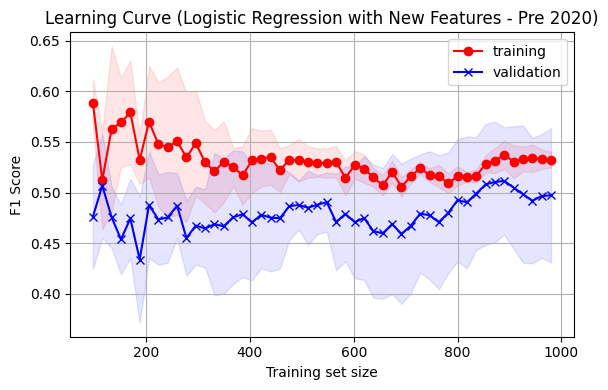

In [473]:
# Pre 2020
# 1. Define target variable
df_pre2020['Win'] = (df_pre2020['Winner'] == df_pre2020['Team 1']).astype(int)
#df_post2020.head()

# 2. Select only differential features
diff_features = [
    'T1_Offense_vs_T2_Defense', 'T2_Offense_vs_T1_Defense',
    'T1_Turnovers_vs_T2_CausedTOs', 'T2_Turnovers_vs_T1_CausedTOs',
    'T1_ManUp_vs_T2_ManDown', 'T2_ManUp_vs_T1_ManDown',
    'T1_Goalie_vs_T2_Shooting', 'T2_Goalie_vs_T1_Shooting',
    'Faceoff_Percent_Diff', 'RPI_Diff', 'Margin_Diff'
]

# Create X and y
X = df_pre2020[diff_features].copy()
y = df_pre2020['Win']

# 3. Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Train logistic regression
# Don't use regularization
model_pre2020 = LogisticRegression(solver='liblinear')
model_pre2020.fit(X_train, y_train)

# 5. Evaluate model
y_pred = model_pre2020.predict(X_test)
accuracy_pre2020 = accuracy_score(y_test, y_pred)
f1_pre2020 = f1_score(y_test, y_pred)
report_pre2020 = classification_report(y_test, y_pred)

# 6. Feature importance
coefficients_pre2020 = pd.DataFrame({
    'Feature': diff_features,
    'Coefficient': model_pre2020.coef_[0]
}).sort_values(by='Coefficient', key=abs, ascending=False)

print(f"Accuracy: {accuracy_pre2020:.3f}")
print(f"F1 Score: {f1_pre2020:.3f}")
print("\nClassification Report:\n", report_pre2020)
print(coefficients_pre2020.head(10))  # Top 10 features
print("\n10 Least Influential Features:")
print(coefficients_pre2020.tail(10))

# 8. Learning Curve
train_sizes, train_scores, val_scores = learning_curve(
    estimator=LogisticRegression(max_iter=1000),
    X=X,
    y=y,
    train_sizes=np.linspace(0.1, 1.0, 50),
    cv=5,
    scoring=make_scorer(f1_score),
    n_jobs=-1,
    random_state=42
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# 9. Plotting
plt.figure(figsize=(6, 4))
plt.plot(train_sizes, train_mean, 'r-', label='training', marker='o')
plt.plot(train_sizes, val_mean, 'b-', label='validation', marker='x')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='red', alpha=0.1)
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, color='blue', alpha=0.1)
plt.xlabel('Training set size')
plt.ylabel('F1 Score')
plt.title('Learning Curve (Logistic Regression with New Features - Pre 2020)')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()


Accuracy: 0.711
F1 Score: 0.617

Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.83      0.77       207
           1       0.70      0.55      0.62       150

    accuracy                           0.71       357
   macro avg       0.71      0.69      0.69       357
weighted avg       0.71      0.71      0.70       357

                         Feature  Coefficient
12                   Margin_Diff     1.051762
11                      RPI_Diff     0.716627
2   T1_Turnovers_vs_T2_CausedTOs    -0.244741
8       T1_Goalie_vs_T2_Shooting    -0.226992
9       T2_Goalie_vs_T1_Shooting     0.224600
1       T2_Offense_vs_T1_Defense    -0.180826
3   T2_Turnovers_vs_T1_CausedTOs    -0.054206
5        T2_Clear_vs_T1_OppClear    -0.033540
4        T1_Clear_vs_T2_OppClear    -0.031328
6         T1_ManUp_vs_T2_ManDown     0.024387

10 Least Influential Features:
                         Feature  Coefficient
8       T1_Goalie_vs_T2_Shooting

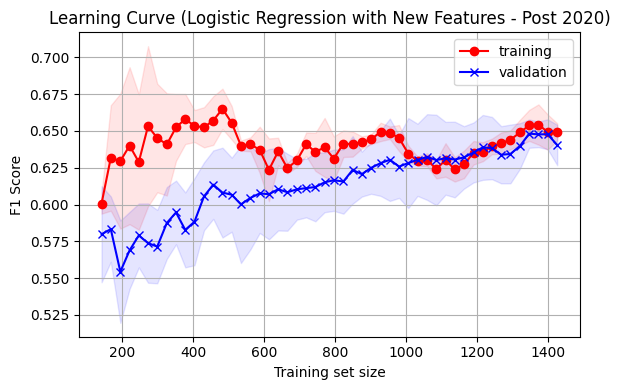

In [474]:
# Post 2020
# 1. Define target variable
df_post2020['Win'] = (df_post2020['Winner'] == df_post2020['Team 1']).astype(int)
#df_post2020.head()

# 2. Select only differential features
diff_features = [
    'T1_Offense_vs_T2_Defense', 'T2_Offense_vs_T1_Defense',
    'T1_Turnovers_vs_T2_CausedTOs', 'T2_Turnovers_vs_T1_CausedTOs',
    'T1_Clear_vs_T2_OppClear', 'T2_Clear_vs_T1_OppClear',
    'T1_ManUp_vs_T2_ManDown', 'T2_ManUp_vs_T1_ManDown',
    'T1_Goalie_vs_T2_Shooting', 'T2_Goalie_vs_T1_Shooting',
    'Faceoff_Percent_Diff', 'RPI_Diff', 'Margin_Diff'
]

# Create X and y
X = df_post2020[diff_features].copy()
y = df_post2020['Win']

# 3. Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Train logistic regression
# Don't use regularization
model_post2020 = LogisticRegression(solver='liblinear')
model_post2020.fit(X_train, y_train)

# 5. Evaluate model
y_pred = model_post2020.predict(X_test)
accuracy_post2020 = accuracy_score(y_test, y_pred)
f1_post2020 = f1_score(y_test, y_pred)
report_post2020 = classification_report(y_test, y_pred)

# 6. Feature importance
coefficients_post2020 = pd.DataFrame({
    'Feature': diff_features,
    'Coefficient': model_post2020.coef_[0]
}).sort_values(by='Coefficient', key=abs, ascending=False)

print(f"Accuracy: {accuracy_post2020:.3f}")
print(f"F1 Score: {f1_post2020:.3f}")
print("\nClassification Report:\n", report_post2020)
print(coefficients_post2020.head(10))  # Top 10 features
print("\n10 Least Influential Features:")
print(coefficients_post2020.tail(10))

# 8. Learning Curve
train_sizes, train_scores, val_scores = learning_curve(
    estimator=LogisticRegression(max_iter=1000),
    X=X,
    y=y,
    train_sizes=np.linspace(0.1, 1.0, 50),
    cv=5,
    scoring=make_scorer(f1_score),
    n_jobs=-1,
    random_state=42
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# 9. Plotting
plt.figure(figsize=(6, 4))
plt.plot(train_sizes, train_mean, 'r-', label='training', marker='o')
plt.plot(train_sizes, val_mean, 'b-', label='validation', marker='x')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='red', alpha=0.1)
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, color='blue', alpha=0.1)
plt.xlabel('Training set size')
plt.ylabel('F1 Score')
plt.title('Learning Curve (Logistic Regression with New Features - Post 2020)')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()


Now, just for fun, let's add back in our original differential features.

In [475]:
# normalize our original differential features
def normalize_differential_features_only(df):
    # Identify differential columns
    diff_cols = [col for col in df.columns if col.startswith("Diff ") and df[col].notna().all()]

    # Standardize only those columns
    scaler = StandardScaler()
    df[diff_cols] = scaler.fit_transform(df[diff_cols])

    return df

# Apply normalization to both datasets
df_pre2020 = normalize_differential_features_only(df_pre2020)
df_post2020 = normalize_differential_features_only(df_post2020)

Accuracy: 0.665
F1 Score: 0.487

Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.83      0.75       150
           1       0.60      0.41      0.49        95

    accuracy                           0.67       245
   macro avg       0.64      0.62      0.62       245
weighted avg       0.65      0.67      0.65       245

                          Feature  Coefficient
8                        Diff RPI     2.008133
9            Diff Faceoff Percent     1.205745
1               Diff Save Percent    -0.845829
16              Diff Shot Percent     0.830479
11          Diff Clearing Percent     0.409324
13  Diff Man Down Defense Percent     0.206299
21    Diff Man Up Offense Percent    -0.203809
2        T2_Goalie_vs_T1_Shooting     0.196162
19            Diff Average Margin     0.168654
0           Diff Assists per Game     0.123138

10 Least Influential Features:
                           Feature  Coefficient
17  Diff Caused Tur

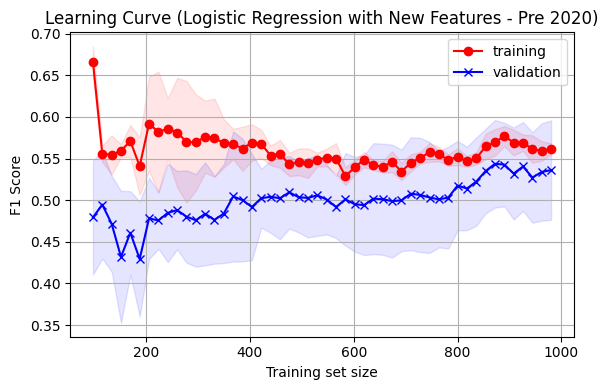

In [550]:
# pre 2020
# 1. Define target variable
df_pre2020['Win'] = (df_pre2020['Winner'] == df_pre2020['Team 1']).astype(int)
#df_post2020.head()

# 2. Select only differential features
all_diff_features = [col for col in df_pre2020.columns if col.startswith("Diff ") and df_pre2020[col].notna().all()]

diff_features = list(set(
    [col for col in all_diff_features if 'Games Played' not in col] +
    [
        'T1_Offense_vs_T2_Defense', 'T2_Offense_vs_T1_Defense',
        'T1_Turnovers_vs_T2_CausedTOs', 'T2_Turnovers_vs_T1_CausedTOs',
        'T1_ManUp_vs_T2_ManDown', 'T2_ManUp_vs_T1_ManDown',
        'T1_Goalie_vs_T2_Shooting', 'T2_Goalie_vs_T1_Shooting',
        'Faceoff_Percent_Diff', 'RPI_Diff', 'Margin_Diff'
    ]
))

# remove duplicates
to_remove = ['RPI_Diff', 'Margin_Diff', 'Faceoff_Percent_Diff', 'Diff Saves per Game']
diff_features = [col for col in diff_features if col not in to_remove]


# Create X and y
X = df_pre2020[diff_features].copy()
y = df_pre2020['Win']

# 3. Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Train logistic regression
# Train logistic regression with L2 regularization
model_pre2020 = LogisticRegression(solver='liblinear')
model_pre2020.fit(X_train, y_train)

# 5. Evaluate model
y_pred = model_pre2020.predict(X_test)
accuracy_pre2020 = accuracy_score(y_test, y_pred)
f1_pre2020 = f1_score(y_test, y_pred)
report_pre2020 = classification_report(y_test, y_pred)

# 6. Feature importance
coefficients_pre2020 = pd.DataFrame({
    'Feature': diff_features,
    'Coefficient': model_pre2020.coef_[0]
}).sort_values(by='Coefficient', key=abs, ascending=False)

print(f"Accuracy: {accuracy_pre2020:.3f}")
print(f"F1 Score: {f1_pre2020:.3f}")
print("\nClassification Report:\n", report_pre2020)
print(coefficients_pre2020.head(10))  # Top 10 features
print("\n10 Least Influential Features:")
print(coefficients_pre2020.tail(10))

# 8. Learning Curve
train_sizes, train_scores, val_scores = learning_curve(
    estimator=LogisticRegression(max_iter=1000),
    X=X,
    y=y,
    train_sizes=np.linspace(0.1, 1.0, 50),
    cv=5,
    scoring=make_scorer(f1_score),
    n_jobs=-1,
    random_state=42
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# 9. Plotting
plt.figure(figsize=(6, 4))
plt.plot(train_sizes, train_mean, 'r-', label='training', marker='o')
plt.plot(train_sizes, val_mean, 'b-', label='validation', marker='x')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='red', alpha=0.1)
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, color='blue', alpha=0.1)
plt.xlabel('Training set size')
plt.ylabel('F1 Score')
plt.title('Learning Curve (Logistic Regression with New Features - Pre 2020)')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()




Accuracy: 0.717
F1 Score: 0.635

Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.81      0.77       207
           1       0.69      0.59      0.64       150

    accuracy                           0.72       357
   macro avg       0.71      0.70      0.70       357
weighted avg       0.71      0.72      0.71       357

                          Feature  Coefficient
9                        Diff RPI     3.528152
2               Diff Save Percent    -0.986952
19              Diff Shot Percent     0.978353
10           Diff Faceoff Percent     0.611993
16    Diff Opponent Clear Percent    -0.283996
12          Diff Clearing Percent     0.281550
14  Diff Man Down Defense Percent    -0.224720
24    Diff Man Up Offense Percent     0.224339
13   T1_Turnovers_vs_T2_CausedTOs    -0.160274
23   T2_Turnovers_vs_T1_CausedTOs    -0.137644

10 Least Influential Features:
                           Feature  Coefficient
22             Diff

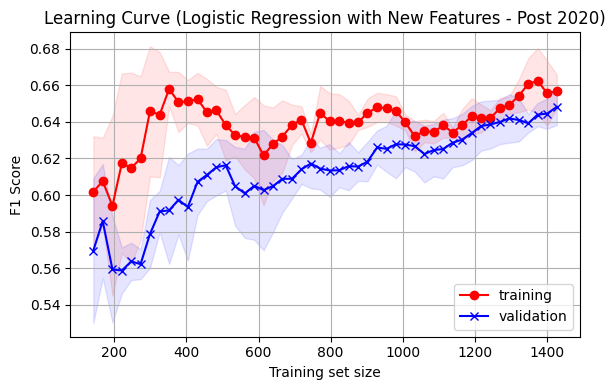

In [551]:
# post 2020
# 1. Define target variable
df_post2020['Win'] = (df_post2020['Winner'] == df_post2020['Team 1']).astype(int)
#df_post2020.head()

# 2. Select only differential features
all_diff_features = [col for col in df_post2020.columns if col.startswith("Diff ") and df_post2020[col].notna().all()]

diff_features = list(set(
    [col for col in all_diff_features if 'Games Played' not in col] +
    [
        'T1_Offense_vs_T2_Defense', 'T2_Offense_vs_T1_Defense',
        'T1_Turnovers_vs_T2_CausedTOs', 'T2_Turnovers_vs_T1_CausedTOs',
        'T1_Clear_vs_T2_OppClear', 'T2_Clear_vs_T1_OppClear',
        'T1_ManUp_vs_T2_ManDown', 'T2_ManUp_vs_T1_ManDown',
        'T1_Goalie_vs_T2_Shooting', 'T2_Goalie_vs_T1_Shooting',
        'Faceoff_Percent_Diff', 'RPI_Diff', 'Margin_Diff'
    ]
))

# remove duplicates
to_remove = ['RPI_Diff', 'Margin_Diff', 'Faceoff_Percent_Diff', 'Diff Saves per Game']
diff_features = [col for col in diff_features if col not in to_remove]


# Create X and y
X = df_post2020[diff_features].copy()
y = df_post2020['Win']

# 3. Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Train logistic regression
# Don't use regularization
model_post2020 = LogisticRegression(solver='liblinear')
model_post2020.fit(X_train, y_train)

# 5. Evaluate model
y_pred = model_post2020.predict(X_test)
accuracy_post2020 = accuracy_score(y_test, y_pred)
f1_post2020 = f1_score(y_test, y_pred)
report_post2020 = classification_report(y_test, y_pred)

# 6. Feature importance
coefficients_post2020 = pd.DataFrame({
    'Feature': diff_features,
    'Coefficient': model_post2020.coef_[0]
}).sort_values(by='Coefficient', key=abs, ascending=False)

print(f"Accuracy: {accuracy_post2020:.3f}")
print(f"F1 Score: {f1_post2020:.3f}")
print("\nClassification Report:\n", report_post2020)
print(coefficients_post2020.head(10))  # Top 10 features
print("\n10 Least Influential Features:")
print(coefficients_post2020.tail(10))

# 8. Learning Curve
train_sizes, train_scores, val_scores = learning_curve(
    estimator=LogisticRegression(max_iter=1000),
    X=X,
    y=y,
    train_sizes=np.linspace(0.1, 1.0, 50),
    cv=5,
    scoring=make_scorer(f1_score),
    n_jobs=-1,
    random_state=42
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# 9. Plotting
plt.figure(figsize=(6, 4))
plt.plot(train_sizes, train_mean, 'r-', label='training', marker='o')
plt.plot(train_sizes, val_mean, 'b-', label='validation', marker='x')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='red', alpha=0.1)
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, color='blue', alpha=0.1)
plt.xlabel('Training set size')
plt.ylabel('F1 Score')
plt.title('Learning Curve (Logistic Regression with New Features - Post 2020)')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()


This is interesting. As we can see, most of the top 10 important features are still from our original list of differential features.

# Feature Engineering: Rolling Averages

Now we will try to add in new statistics that could help us learn more about how a team is playing. We will add in rolling averages that will give us a sense of how much momentum each team has.

In [478]:
# imports
import pandas as pd

# used for printing entire rows
from IPython.display import display

In [479]:
# Define the path to CSV file
file_path = "/content/drive/MyDrive/Colab Notebooks/Final Project Real Folder/Final Data/ncaa_lacrosse_with_RPI.csv"

# Load the data
df = pd.read_csv(file_path)

#print("dataframe size", df.shape)

## Normal Pre-Processing

In [480]:
# add a goalie save pct (saves per game / [saves per game + goals allowed per game])

# Calculate goalie save percentage for Team 1
df['Team 1 Save Percent'] = df['Team 1 Saves per Game'] / (
    df['Team 1 Saves per Game'] + df['Team 1 Goals Allowed per Game']
)

# Calculate goalie save percentage for Team 2
df['Team 2 Save Percent'] = df['Team 2 Saves per Game'] / (
    df['Team 2 Saves per Game'] + df['Team 2 Goals Allowed per Game']
)

In [481]:
# get the game count

# Ensure Date is a datetime object
df['Date'] = pd.to_datetime(df['Date'])

# Sort by date to ensure correct game order
df = df.sort_values(by='Date').reset_index(drop=True)

# Function to count games per team up to each date
def add_game_counts(df):
    team_game_counts = {}

    game_counts = []

    for i, row in df.iterrows():
        df['Year'] = df['Date'].dt.year
        year = row['Year']
        team1 = row['Team 1']
        team2 = row['Team 2']
        date = row['Date']

        # Create keys based on year and team
        key1 = (year, team1)
        key2 = (year, team2)

        # Get current game count
        count1 = team_game_counts.get(key1, 0)
        count2 = team_game_counts.get(key2, 0)

        game_counts.append((count1, count2))

        # Increment game counts AFTER the game
        team_game_counts[key1] = count1 + 1
        team_game_counts[key2] = count2 + 1

    df['Team 1 Games Played'] = [c[0] for c in game_counts]
    df['Team 2 Games Played'] = [c[1] for c in game_counts]

    return df

# Add game counts
df = add_game_counts(df)

# we will filter after we compute the rolling averages

# Preview cleaned data
#df.head()

#print("dataframe size", df.shape)


In [482]:
# Remove games with a 0-0 score (invalid data)
df = df[~((df['Score 1'] == 0) & (df['Score 2'] == 0))]

# Optional: reset index after filtering
df = df.reset_index(drop=True)

#print("dataframe size", df.shape)

## Computing Rolling Averages

Before we comtinue preprocessing the data, we need to compute rolling averages. Before we do this, we will need a function to help us test it.

In [ ]:
# this is a testing function, it prints given statistics from the entire given year for the given team
def get_team_season_subset(name, year, df, columns_to_print):
    subset = df[((df['Team 1'] == name) | (df['Team 2'] == name)) & (df['Year'] == year)]
    return subset[columns_to_print]


# Example: Get 2022 data for 'duke'
'''
columns_to_view = ['Date', 'Team 1', 'Team 2', 'Score 1', 'Score 2',
                   ]
subset = get_team_season_subset('duke', 2024, df, columns_to_view)
subset = subset.sort_values(by='Date')
print(subset)
'''

           Date          Team 1           Team 2  Score 1  Score 2
3584 2024-02-03      bellarmine             duke     12.0     20.0
3608 2024-02-10            duke       high point     21.0      9.0
3658 2024-02-17  saint joseph's             duke     10.0     19.0
3685 2024-02-23    jacksonville             duke      7.0     23.0
3730 2024-03-01            penn             duke     14.0     12.0
3761 2024-03-03       princeton             duke      8.0     17.0
3799 2024-03-09            duke  loyola maryland     16.0     10.0
3814 2024-03-13      providence             duke      6.0     21.0
3817 2024-03-16            duke         richmond     12.0      3.0
3857 2024-03-20            duke         syracuse      4.0     10.0
3895 2024-03-24            duke           denver     11.0      7.0
3903 2024-03-27       boston u.             duke     10.0     11.0
3980 2024-04-07      notre dame             duke     15.0     12.0
4028 2024-04-14        virginia             duke     12.0     

In order to compute rolling averages, we need to add in total statistic features for each statistic. This can be found by multiplying the games played by the average for that statistic.

In [ ]:
def compute_total_stats(df, stat_suffixes):
    """
    Compute total stats for Team 1 and Team 2 for given stat suffixes.

    Parameters:
        df (pd.DataFrame): Input DataFrame.
        stat_suffixes (list of str): e.g., ["Goals per Game", "Shots per Game"]

    Returns:
        pd.DataFrame: DataFrame with total stat columns added.
    """
    df = df.copy()

    for team in ["Team 1", "Team 2"]:
        games_played_col = f"{team} Games Played"

        for stat_suffix in stat_suffixes:
            avg_col = f"{team} {stat_suffix}"
            total_col = f"{avg_col} Total"
            df[total_col] = df[avg_col] * df[games_played_col]

    return df

#df = compute_total_stats(df, ["Assists per Game", 'Clearing Percent'])

In order to compute rolling averages, you need to take the total from current game and subtract it from the total from the previous game (or however many games ago your window is), and then divide this by the games in that window. In order to do this, I made a helper function to get the previous statistic based on a window.

In [ ]:
# this is a function to get the previous statistic
import pandas as pd
import numpy as np

def get_stat_from_nth_previous_game(team_name: str, date, df: pd.DataFrame, window: int, column_name: str):
    # Ensure Date is datetime
    df['Date'] = pd.to_datetime(df['Date'])
    date = pd.to_datetime(date)
    year = date.year

    # Filter games in the same year with the team
    year_games = df[
        ((df['Team 1'] == team_name) | (df['Team 2'] == team_name)) &
        (df['Date'].dt.year == year)
    ].copy()

    # Games before or on the date
    past_games = year_games[year_games['Date'] <= date].sort_values(by='Date', ascending=False)

    # Try to get the nth previous game
    if len(past_games) >= window:
        candidate_game = past_games.iloc[window - 1]
    else:
        # Fallback to first game of the year
        sorted_games = year_games.sort_values(by='Date')
        if not sorted_games.empty:
            candidate_game = sorted_games.iloc[0]
        else:
            return np.nan  # No games at all that year

    # Determine the correct column
    if candidate_game['Team 1'] == team_name:
        stat_column = f'Team 1 {column_name}'
    elif candidate_game['Team 2'] == team_name:
        stat_column = f'Team 2 {column_name}'
    else:
        return np.nan

    # If value is missing, search forward for next non-NaN
    if pd.isna(candidate_game.get(stat_column)):
        future_games = year_games[year_games['Date'] > candidate_game['Date']].sort_values(by='Date')

        for _, row in future_games.iterrows():
            if row['Team 1'] == team_name:
                stat_col = f'Team 1 {column_name}'
            elif row['Team 2'] == team_name:
                stat_col = f'Team 2 {column_name}'
            else:
                continue

            value = row.get(stat_col)
            if not pd.isna(value):
                return value

        return np.nan  # Still no valid value found

    return candidate_game.get(stat_column)

value = get_stat_from_nth_previous_game("lafayette", "2024-03-24", df, 100, "Goals per Game")
print("Stat value:", value)

Stat value: 6.0


This function actually computes all of the rolling averages for the entire dataframe.

In [ ]:
def compute_rolling_avg_from_totals(df, stat_suffixes, window):
    """
    Compute rolling averages from total stats using difference between current and N-games-ago totals.
    Adjusts denominator when fewer than 'window' games are available.

    Parameters:
        df (pd.DataFrame): Input DataFrame
        stat_suffixes (list of str): e.g., ["Goals per Game"]
        window (int): Rolling window size

    Returns:
        pd.DataFrame: Updated DataFrame with rolling average columns.
    """
    df = df.copy()
    df['Date'] = pd.to_datetime(df['Date'])

    for team_col in ["Team 1", "Team 2"]:
        games_col = f"{team_col} Games Played"

        for stat_suffix in stat_suffixes:
            total_col = f"{team_col} {stat_suffix} Total"
            rolling_col = f"{team_col} {stat_suffix} RollingAvg_{window}"

            rolling_avgs = []

            for _, row in df.iterrows():
                team_name = row[team_col]
                date = row['Date']
                current_total = row.get(total_col)
                current_games_played = row.get(games_col)

                # because this function returns the first available number, if the window is greater than games played, just return 0
                if (window >= current_games_played):
                    prev_total = 0
                else:
                    prev_total = get_stat_from_nth_previous_game(
                        team_name=team_name,
                        date=date,
                        df=df,
                        window=window + 1,
                        column_name=f"{stat_suffix} Total"
                    )

                if pd.notna(current_total) and pd.notna(prev_total) and pd.notna(current_games_played):
                    games_in_window = min(window, current_games_played)
                    if games_in_window > 0:
                        rolling_avg = (current_total - prev_total) / games_in_window
                    else:
                        rolling_avg = np.nan
                else:
                    rolling_avg = np.nan

                rolling_avgs.append(rolling_avg)

            df[rolling_col] = rolling_avgs

    return df


In [ ]:
#df = compute_rolling_avg_from_totals(df, ["Goals per Game"], window=3)

totals_features = [
    'Assists per Game', 'Caused Turnovers per Game', 'Clearing Percent', 'Faceoff Percent', 'Groundballs per Game', 'Man Down Defense Percent', 'Man Up Offense Percent', 'Opponent Clear Percent',
    'Goals per Game', 'Goals Allowed per Game', 'Average Margin', 'Shot Percent', 'Turnovers per Game', 'Save Percent', 'RPI'
]

# first, calculate the total stats
df = compute_total_stats(df, totals_features)

df = compute_rolling_avg_from_totals(df, totals_features, window=3)

# Save to Google Drive so we don't have to re do
save_path = "/content/drive/MyDrive/Colab Notebooks/Final Project Real Folder/Final Data/ncaa_lacrosse_with_RPI_rolling3.csv"
df.to_csv(save_path, index=False)

Below is some code that helped me test that it worked.

In [332]:
'''
# Example: Get 2022 data for 'duke', showing rolling goal stats and game date
#columns_to_view = ['Date', 'Team 1', 'Team 2', 'Score 1', 'Score 2', 'Team 1 Assists per Game', 'Team 2 Assists per Game',
                   #'Team 1 Assists per Game Total', 'Team 2 Assists per Game Total', 'Team 1 Assists per Game RollingAvg_3', 'Team 2 Assists per Game RollingAvg_3'
                   #]

columns_to_view = ['Date', 'Team 1', 'Team 2', 'Score 1', 'Score 2', 'Team 1 Clearing Percent', 'Team 2 Clearing Percent',
                   'Team 1 Clearing Percent Total', 'Team 2 Clearing Percent Total', 'Team 1 Clearing Percent RollingAvg_3', 'Team 2 Clearing Percent RollingAvg_3'
                   ]
subset = get_team_season_subset('lafayette', 2024, df, columns_to_view)
subset = subset.sort_values(by='Date')
print(subset)
'''


"\n# Example: Get 2022 data for 'duke', showing rolling goal stats and game date\n#columns_to_view = ['Date', 'Team 1', 'Team 2', 'Score 1', 'Score 2', 'Team 1 Assists per Game', 'Team 2 Assists per Game',\n                   #'Team 1 Assists per Game Total', 'Team 2 Assists per Game Total', 'Team 1 Assists per Game RollingAvg_3', 'Team 2 Assists per Game RollingAvg_3'\n                   #]\n\ncolumns_to_view = ['Date', 'Team 1', 'Team 2', 'Score 1', 'Score 2', 'Team 1 Clearing Percent', 'Team 2 Clearing Percent',\n                   'Team 1 Clearing Percent Total', 'Team 2 Clearing Percent Total', 'Team 1 Clearing Percent RollingAvg_3', 'Team 2 Clearing Percent RollingAvg_3'\n                   ]\nsubset = get_team_season_subset('lafayette', 2024, df, columns_to_view)\nsubset = subset.sort_values(by='Date')\nprint(subset)\n"

In [333]:
'''
# Example: Get 2022 data for 'duke', showing rolling goal stats and game date
columns_to_view = ['Date', 'Team 1', 'Team 2', 'Score 1', 'Score 2', 'Team 1 Goals per Game', 'Team 2 Goals per Game', 'Team 1 Goals per Game RollingAvg_3', 'Team 2 Goals per Game RollingAvg_3'
                   ]
subset = get_team_season_subset('lafayette', 2024, df, columns_to_view)
subset = subset.sort_values(by='Date')
print(subset)
'''

"\n# Example: Get 2022 data for 'duke', showing rolling goal stats and game date\ncolumns_to_view = ['Date', 'Team 1', 'Team 2', 'Score 1', 'Score 2', 'Team 1 Goals per Game', 'Team 2 Goals per Game', 'Team 1 Goals per Game RollingAvg_3', 'Team 2 Goals per Game RollingAvg_3'\n                   ]\nsubset = get_team_season_subset('lafayette', 2024, df, columns_to_view)\nsubset = subset.sort_values(by='Date')\nprint(subset)\n"

## Logistic Regression on Rolling Stats

### Pre-Process the Data

In [483]:
# imports
import pandas as pd

from sklearn.preprocessing import StandardScaler

In [484]:
# Load in our dataset
# Define the path to your CSV file
file_path = "/content/drive/MyDrive/Colab Notebooks/Final Project Real Folder/Final Data/ncaa_lacrosse_with_RPI_rolling3.csv"

# Load the data
df = pd.read_csv(file_path)

print(df.shape)

(4151, 101)


In [485]:
# games played is already in the data, just need to filter

# Filter: keep only games where both teams have played at least 2 games before this one
df = df[(df['Team 1 Games Played'] >= 2) & (df['Team 2 Games Played'] >= 2)]

# Preview cleaned data
#df.head()

print(df.shape)


(3416, 101)


In [486]:
# Remove games with a 0-0 score (invalid data)
df = df[~((df['Score 1'] == 0) & (df['Score 2'] == 0))]

print(df.shape)

(3416, 101)


In [487]:
# List of Opponent Clear Percent columns to exclude from NaN filtering
excluded_columns = ['Team 1 Opponent Clear Percent', 'Team 2 Opponent Clear Percent', 'Team 1 Opponent Clear Percent RollingAvg_3', 'Team 2 Opponent Clear Percent RollingAvg_3', 'Team 1 Opponent Clear Percent Total', 'Team 2 Opponent Clear Percent Total']

# Columns to check for NaNs (all except excluded ones)
columns_to_check = [col for col in df.columns if col not in excluded_columns]

# Drop rows with NaNs in any of those columns
df = df.dropna(subset=columns_to_check).reset_index(drop=True)

# Preview cleaned data
#df.head()

print(df.shape)

(3009, 101)


In [488]:
# Split the dataset by year so I can do the same thing to opponent clear percentage AFTER 2020
df_pre2020 = df[(df['Year'] >= 2015) & (df['Year'] <= 2019)].copy()
df_post2020 = df[(df['Year'] >= 2020) & (df['Year'] <= 2024)].copy()


# Check sizes
print("Pre-2020 dataset shape:", df_pre2020.shape)
print("2020+ dataset shape:", df_post2020.shape)



Pre-2020 dataset shape: (1225, 101)
2020+ dataset shape: (1784, 101)


In [489]:
# drop NaN in opponent clear percentage for post 2020
df_post2020 = df_post2020.dropna(subset=['Team 1 Opponent Clear Percent', 'Team 2 Opponent Clear Percent', 'Team 1 Opponent Clear Percent RollingAvg_3', 'Team 2 Opponent Clear Percent RollingAvg_3', 'Team 1 Opponent Clear Percent Total', 'Team 2 Opponent Clear Percent Total']).reset_index(drop=True)

In [490]:
print("Pre-2020 dataset shape:", df_pre2020.shape)
print("2020+ dataset shape:", df_post2020.shape)

Pre-2020 dataset shape: (1225, 101)
2020+ dataset shape: (1784, 101)


Now we need to create differential features for this dataset. Since we have so many features now, this will take some more code.

In [491]:
# Identify matching statistic pairs
team1_prefix = "Team 1 "
team2_prefix = "Team 2 "

# Collect column pairs for which both Team 1 and Team 2 have values
stat_columns = [
    ('Team 1 Assists per Game', 'Team 2 Assists per Game'),
    ('Team 1 Caused Turnovers per Game', 'Team 2 Caused Turnovers per Game'),
    ('Team 1 Clearing Percent', 'Team 2 Clearing Percent'),
    ('Team 1 Faceoff Percent', 'Team 2 Faceoff Percent'),
    ('Team 1 Groundballs per Game', 'Team 2 Groundballs per Game'),
    ('Team 1 Man Down Defense Percent', 'Team 2 Man Down Defense Percent'),
    ('Team 1 Man Up Offense Percent', 'Team 2 Man Up Offense Percent'),
    ('Team 1 Opponent Clear Percent', 'Team 2 Opponent Clear Percent'),
    ('Team 1 Goals per Game', 'Team 2 Goals per Game'),
    ('Team 1 Saves per Game', 'Team 2 Saves per Game'),
    ('Team 1 Goals Allowed per Game', 'Team 2 Goals Allowed per Game'),
    ('Team 1 Average Margin', 'Team 2 Average Margin'),
    ('Team 1 Shot Percent', 'Team 2 Shot Percent'),
    ('Team 1 Turnovers per Game', 'Team 2 Turnovers per Game'),
    ('Team 1 RPI', 'Team 2 RPI'),
    ('Team 1 Save Percent', 'Team 2 Save Percent'),
    ('Team 1 Games Played', 'Team 2 Games Played'),
    ('Team 1 Assists per Game RollingAvg_3', 'Team 2 Assists per Game RollingAvg_3'),
    ('Team 1 Caused Turnovers per Game RollingAvg_3', 'Team 2 Caused Turnovers per Game RollingAvg_3'),
    ('Team 1 Clearing Percent RollingAvg_3', 'Team 2 Clearing Percent RollingAvg_3'),
    ('Team 1 Faceoff Percent RollingAvg_3', 'Team 2 Faceoff Percent RollingAvg_3'),
    ('Team 1 Groundballs per Game RollingAvg_3', 'Team 2 Groundballs per Game RollingAvg_3'),
    ('Team 1 Man Down Defense Percent RollingAvg_3', 'Team 2 Man Down Defense Percent RollingAvg_3'),
    ('Team 1 Man Up Offense Percent RollingAvg_3', 'Team 2 Man Up Offense Percent RollingAvg_3'),
    ('Team 1 Opponent Clear Percent RollingAvg_3', 'Team 2 Opponent Clear Percent RollingAvg_3'),
    ('Team 1 Goals per Game RollingAvg_3', 'Team 2 Goals per Game RollingAvg_3'),
    ('Team 1 Goals Allowed per Game RollingAvg_3', 'Team 2 Goals Allowed per Game RollingAvg_3'),
    ('Team 1 Average Margin RollingAvg_3', 'Team 2 Average Margin RollingAvg_3'),
    ('Team 1 Shot Percent RollingAvg_3', 'Team 2 Shot Percent RollingAvg_3'),
    ('Team 1 Turnovers per Game RollingAvg_3', 'Team 2 Turnovers per Game RollingAvg_3'),
    ('Team 1 Save Percent RollingAvg_3', 'Team 2 Save Percent RollingAvg_3'),
    ('Team 1 RPI RollingAvg_3', 'Team 2 RPI RollingAvg_3')
]



# Function to compute differential features
def add_differential_features(df, stat_columns):
    for t1_col, t2_col in stat_columns:
        diff_col = "Diff " + t1_col[len(team1_prefix):]
        df[diff_col] = df[t1_col] - df[t2_col]
    return df

# Apply to both datasets
df_pre2020 = add_differential_features(df_pre2020, stat_columns)
df_post2020 = add_differential_features(df_post2020, stat_columns)

# Preview updated data
df_pre2020[[col for col in df_pre2020.columns if col.startswith("Diff")]].head()


,Diff Assists per Game,Diff Caused Turnovers per Game,Diff Clearing Percent,Diff Faceoff Percent,Diff Groundballs per Game,Diff Man Down Defense Percent,Diff Man Up Offense Percent,Diff Opponent Clear Percent,Diff Goals per Game,Diff Saves per Game,...,Diff Man Down Defense Percent RollingAvg_3,Diff Man Up Offense Percent RollingAvg_3,Diff Opponent Clear Percent RollingAvg_3,Diff Goals per Game RollingAvg_3,Diff Goals Allowed per Game RollingAvg_3,Diff Average Margin RollingAvg_3,Diff Shot Percent RollingAvg_3,Diff Turnovers per Game RollingAvg_3,Diff Save Percent RollingAvg_3,Diff RPI RollingAvg_3
0,1.50,-0.50,-0.027,-0.052,3.50,-0.130,-0.167,NaN,2.00,1.5,...,-0.130,-0.167,NaN,2.00,4.00,-2.00,0.007,-4.00,-0.113306,0.00000
1,-6.00,2.00,-0.033,-0.189,-10.00,0.047,-0.714,NaN,-8.50,2.5,...,0.047,-0.714,NaN,-8.50,-3.50,-5.00,-0.194,-0.50,0.157895,-0.25000
2,0.00,2.50,0.041,-0.215,-10.00,-0.127,0.178,NaN,-1.50,-2.0,...,-0.127,0.178,NaN,-1.50,-3.50,2.00,0.002,-9.50,0.032891,0.25000
3,4.33,0.67,-0.045,-0.215,-6.34,-0.118,0.092,NaN,5.33,-1.0,...,-0.118,0.092,NaN,5.33,4.67,0.67,0.257,0.67,-0.166078,0.18750
4,-3.33,-4.33,0.031,0.057,-8.00,-0.378,0.083,NaN,-3.67,2.5,...,-0.378,0.083,NaN,-3.67,0.17,-3.83,-0.060,6.50,0.052010,0.02778


Now, let's normalize our data.

In [492]:
def normalize_differential_features_only(df):
    # Identify differential columns
    diff_cols = [col for col in df.columns if col.startswith("Diff ") and df[col].notna().all()]

    # Standardize only those columns
    scaler = StandardScaler()
    df[diff_cols] = scaler.fit_transform(df[diff_cols])

    return df

# Apply normalization to both datasets
df_pre2020 = normalize_differential_features_only(df_pre2020)
df_post2020 = normalize_differential_features_only(df_post2020)

### Running Logistic Regression

Now let's run the actual logistic regression for both pre and post 2020

In [494]:
# imports
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, make_scorer, f1_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

Accuracy: 0.702
F1 Score: 0.558

Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.84      0.78       150
           1       0.66      0.48      0.56        95

    accuracy                           0.70       245
   macro avg       0.69      0.66      0.67       245
weighted avg       0.70      0.70      0.69       245


Top 10 Most Influential Features:
                                     Feature  Coefficient
13                                  Diff RPI     0.330921
12                   Diff Turnovers per Game    -0.329264
23  Diff Goals Allowed per Game RollingAvg_3     0.264964
19    Diff Groundballs per Game RollingAvg_3    -0.260034
25            Diff Shot Percent RollingAvg_3     0.257886
1             Diff Caused Turnovers per Game     0.226752
22          Diff Goals per Game RollingAvg_3    -0.223878
24          Diff Average Margin RollingAvg_3     0.219359
18         Diff Faceoff Percent RollingAvg_3     0.217705
9

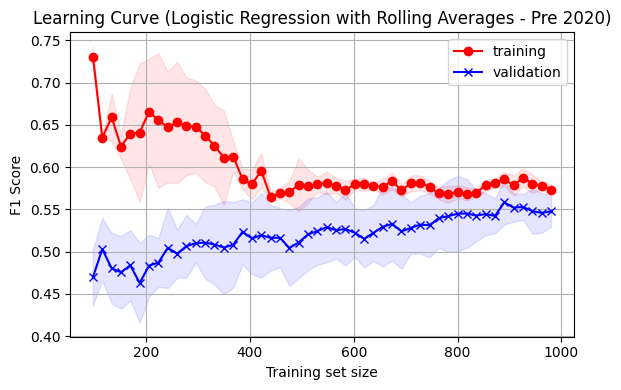

In [495]:
# 1. Define target variable
df_pre2020['Win'] = (df_pre2020['Winner'] == df_pre2020['Team 1']).astype(int)

# 2. Select only differential features
all_diff_features = [col for col in df_pre2020.columns if col.startswith("Diff ") and df_pre2020[col].notna().all()]
diff_features = [col for col in all_diff_features if 'Games Played' not in col]

# 3. Create X and y
X = df_pre2020[diff_features].copy()
y = df_pre2020['Win']

# 4. Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 5. Train logistic regression
model_pre2020 = LogisticRegression(max_iter=1000)
model_pre2020.fit(X_train, y_train)

# 6. Evaluate model
y_pred = model_pre2020.predict(X_test)
accuracy_pre2020 = accuracy_score(y_test, y_pred)
f1_pre2020 = f1_score(y_test, y_pred)
report_pre2020 = classification_report(y_test, y_pred)

# 7. Feature importance
coefficients_pre2020 = pd.DataFrame({
    'Feature': diff_features,
    'Coefficient': model_pre2020.coef_[0]
}).sort_values(by='Coefficient', key=abs, ascending=False)

print(f"Accuracy: {accuracy_pre2020:.3f}")
print(f"F1 Score: {f1_pre2020:.3f}")
print("\nClassification Report:\n", report_pre2020)
print("\nTop 10 Most Influential Features:")
print(coefficients_pre2020.head(10))  # Top 10 features
print("\n10 Least Influential Features:")
print(coefficients_pre2020.tail(10))

# 8. Plot learning curve
train_sizes, train_scores, val_scores = learning_curve(
    estimator=LogisticRegression(max_iter=1000),
    X=X,
    y=y,
    train_sizes=np.linspace(0.1, 1.0, 50),
    cv=5,
    scoring=make_scorer(f1_score),
    n_jobs=-1,
    random_state=42
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# 9. Plotting
plt.figure(figsize=(6, 4))
plt.plot(train_sizes, train_mean, 'r-', label='training', marker='o')
plt.plot(train_sizes, val_mean, 'b-', label='validation', marker='x')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='red', alpha=0.1)
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, color='blue', alpha=0.1)
plt.xlabel('Training set size')
plt.ylabel('F1 Score')
plt.title('Learning Curve (Logistic Regression with Rolling Averages - Pre 2020)')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()


Accuracy: 0.720
F1 Score: 0.630

Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.83      0.77       207
           1       0.71      0.57      0.63       150

    accuracy                           0.72       357
   macro avg       0.72      0.70      0.70       357
weighted avg       0.72      0.72      0.71       357


Top 10 Most Influential Features:
                             Feature  Coefficient
14                          Diff RPI     0.829044
10       Diff Goals Allowed per Game    -0.649145
15                 Diff Save Percent    -0.647839
13           Diff Turnovers per Game    -0.442799
8                Diff Goals per Game    -0.366254
9                Diff Saves per Game     0.333148
24  Diff Goals per Game RollingAvg_3     0.301660
12                 Diff Shot Percent     0.239494
30             Diff RPI RollingAvg_3    -0.220244
26  Diff Average Margin RollingAvg_3     0.216331

10 Least Influential Features:

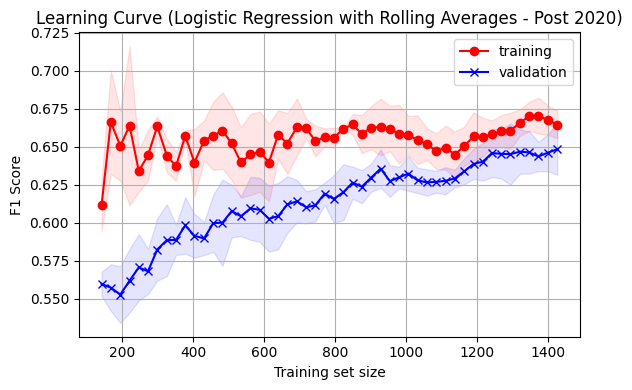

In [496]:
# 1. Define target variable
df_post2020['Win'] = (df_post2020['Winner'] == df_post2020['Team 1']).astype(int)

# 2. Select only differential features
all_diff_features = [col for col in df_post2020.columns if col.startswith("Diff ") and df_post2020[col].notna().all()]
diff_features = [col for col in all_diff_features if 'Games Played' not in col]

# Create X and y
X = df_post2020[diff_features].copy()
y = df_post2020['Win']

# 3. Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Train logistic regression
model_post2020 = LogisticRegression(max_iter=1000)
model_post2020.fit(X_train, y_train)

# 5. Evaluate model
y_pred = model_post2020.predict(X_test)
accuracy_post2020 = accuracy_score(y_test, y_pred)
f1_post2020 = f1_score(y_test, y_pred)
report_post2020 = classification_report(y_test, y_pred)

# 6. Feature importance
coefficients_post2020 = pd.DataFrame({
    'Feature': diff_features,
    'Coefficient': model_post2020.coef_[0]
}).sort_values(by='Coefficient', key=abs, ascending=False)

print(f"Accuracy: {accuracy_post2020:.3f}")
print(f"F1 Score: {f1_post2020:.3f}")
print("\nClassification Report:\n", report_post2020)
print("\nTop 10 Most Influential Features:")
print(coefficients_post2020.head(10))  # Top 10 features
print("\n10 Least Influential Features:")
print(coefficients_post2020.tail(10))

# 7. Plot learning curve (on full dataset)
train_sizes, train_scores, val_scores = learning_curve(
    estimator=LogisticRegression(max_iter=1000),
    X=X,
    y=y,
    train_sizes=np.linspace(0.1, 1.0, 50),
    cv=5,
    scoring=make_scorer(f1_score),
    n_jobs=-1,
    random_state=42
)

# 8. Compute means and standard deviations
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# 9. Plot learning curve
plt.figure(figsize=(6, 4))
plt.plot(train_sizes, train_mean, 'r-', label='training', marker='o')
plt.plot(train_sizes, val_mean, 'b-', label='validation', marker='x')

plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='red', alpha=0.1)
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, color='blue', alpha=0.1)

plt.xlabel('Training set size')
plt.ylabel('F1 Score')
plt.title('Learning Curve (Logistic Regression with Rolling Averages - Post 2020)')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()


Now we will try to run a logistic regression with just the new data.

In [497]:
# imports
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, make_scorer, f1_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

Accuracy: 0.649
F1 Score: 0.463

Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.81      0.74       150
           1       0.57      0.39      0.46        95

    accuracy                           0.65       245
   macro avg       0.62      0.60      0.60       245
weighted avg       0.64      0.65      0.63       245


Top 10 Most Influential Features:
                                       Feature  Coefficient
9             Diff Average Margin RollingAvg_3     0.483540
7             Diff Goals per Game RollingAvg_3    -0.423991
10              Diff Shot Percent RollingAvg_3     0.340730
13                       Diff RPI RollingAvg_3     0.310575
3            Diff Faceoff Percent RollingAvg_3     0.305433
0           Diff Assists per Game RollingAvg_3     0.261378
12              Diff Save Percent RollingAvg_3    -0.250226
4       Diff Groundballs per Game RollingAvg_3    -0.187507
11        Diff Turnovers per Game Rolling

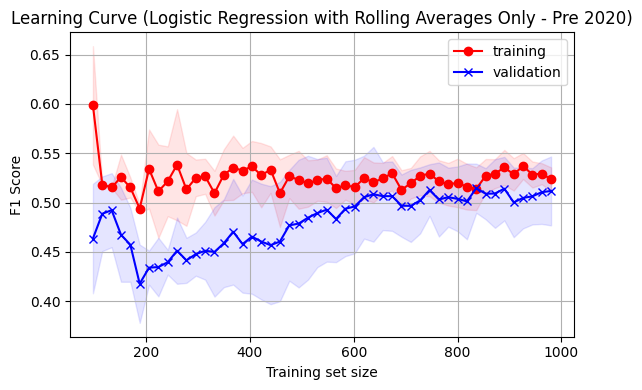

In [498]:
# 1. Define target variable
df_pre2020['Win'] = (df_pre2020['Winner'] == df_pre2020['Team 1']).astype(int)

# 2. Select only differential features THAT ALSO are rolling averages
diff_features = [
    col for col in df_pre2020.columns  # <-- note we're using df_pre2020 here now
    if col.startswith("Diff ") and
       "RollingAvg_3" in col and
       "Games Played" not in col and
       df_pre2020[col].notna().all()
]


# 3. Create X and y
X = df_pre2020[diff_features].copy()
y = df_pre2020['Win']

# 4. Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 5. Train logistic regression
model_pre2020 = LogisticRegression(max_iter=1000)
model_pre2020.fit(X_train, y_train)

# 6. Evaluate model
y_pred = model_pre2020.predict(X_test)
accuracy_pre2020 = accuracy_score(y_test, y_pred)
f1_pre2020 = f1_score(y_test, y_pred)
report_pre2020 = classification_report(y_test, y_pred)

# 7. Feature importance
coefficients_pre2020 = pd.DataFrame({
    'Feature': diff_features,
    'Coefficient': model_pre2020.coef_[0]
}).sort_values(by='Coefficient', key=abs, ascending=False)

print(f"Accuracy: {accuracy_pre2020:.3f}")
print(f"F1 Score: {f1_score(y_test, y_pred):.3f}")
print("\nClassification Report:\n", report_pre2020)
print("\nTop 10 Most Influential Features:")
print(coefficients_pre2020.head(10))  # Top 10 features
print("\n10 Least Influential Features:")
print(coefficients_pre2020.tail(10))

# 8. Plot learning curve
train_sizes, train_scores, val_scores = learning_curve(
    estimator=LogisticRegression(max_iter=1000),
    X=X,
    y=y,
    train_sizes=np.linspace(0.1, 1.0, 50),
    cv=5,
    scoring=make_scorer(f1_score),
    n_jobs=-1,
    random_state=42
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# 9. Plotting
plt.figure(figsize=(6, 4))
plt.plot(train_sizes, train_mean, 'r-', label='training', marker='o')
plt.plot(train_sizes, val_mean, 'b-', label='validation', marker='x')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='red', alpha=0.1)
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, color='blue', alpha=0.1)
plt.xlabel('Training set size')
plt.ylabel('F1 Score')
plt.title('Learning Curve (Logistic Regression with Rolling Averages Only - Pre 2020)')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()


Accuracy: 0.678
F1 Score: 0.605

Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.74      0.73       207
           1       0.62      0.59      0.60       150

    accuracy                           0.68       357
   macro avg       0.67      0.67      0.67       357
weighted avg       0.68      0.68      0.68       357


Top 10 Most Influential Features:
                                     Feature  Coefficient
13                     Diff RPI RollingAvg_3     0.322401
9           Diff Average Margin RollingAvg_3     0.278643
11      Diff Turnovers per Game RollingAvg_3    -0.267365
8   Diff Goals Allowed per Game RollingAvg_3    -0.234580
7           Diff Goals per Game RollingAvg_3     0.207545
12            Diff Save Percent RollingAvg_3    -0.180788
4     Diff Groundballs per Game RollingAvg_3     0.130643
10            Diff Shot Percent RollingAvg_3     0.117012
3          Diff Faceoff Percent RollingAvg_3     0.101646
6

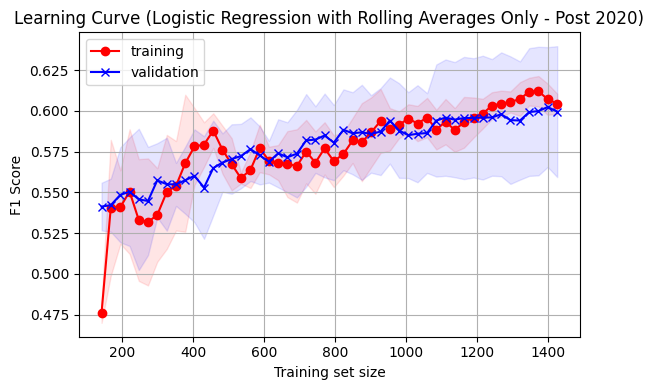

In [499]:
# post 2020
# 1. Define target variable
df_post2020['Win'] = (df_post2020['Winner'] == df_post2020['Team 1']).astype(int)

# 2. Select only differential features THAT ALSO are rolling averages
diff_features = [
    col for col in df_pre2020.columns  # <-- note we're using df_pre2020 here now
    if col.startswith("Diff ") and
       "RollingAvg_3" in col and
       "Games Played" not in col and
       df_pre2020[col].notna().all()
]

# Create X and y
X = df_post2020[diff_features].copy()
y = df_post2020['Win']

# 3. Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Train logistic regression
model_post2020 = LogisticRegression(max_iter=1000)
model_post2020.fit(X_train, y_train)

# 5. Evaluate model
y_pred = model_post2020.predict(X_test)
accuracy_post2020 = accuracy_score(y_test, y_pred)
f1_post2020 = f1_score(y_test, y_pred)
report_post2020 = classification_report(y_test, y_pred)

# 6. Feature importance
coefficients_post2020 = pd.DataFrame({
    'Feature': diff_features,
    'Coefficient': model_post2020.coef_[0]
}).sort_values(by='Coefficient', key=abs, ascending=False)

print(f"Accuracy: {accuracy_post2020:.3f}")
print(f"F1 Score: {f1_score(y_test, y_pred):.3f}")
print("\nClassification Report:\n", report_post2020)
print("\nTop 10 Most Influential Features:")
print(coefficients_post2020.head(10))  # Top 10 features
print("\n10 Least Influential Features:")
print(coefficients_post2020.tail(10))


# 7. Plot learning curve (on full dataset)
train_sizes, train_scores, val_scores = learning_curve(
    estimator=LogisticRegression(max_iter=1000),
    X=X,
    y=y,
    train_sizes=np.linspace(0.1, 1.0, 50),
    cv=5,
    scoring=make_scorer(f1_score),
    n_jobs=-1,
    random_state=42
)

# 8. Compute means and standard deviations
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# 9. Plot learning curve
plt.figure(figsize=(6, 4))
plt.plot(train_sizes, train_mean, 'r-', label='training', marker='o')
plt.plot(train_sizes, val_mean, 'b-', label='validation', marker='x')

plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='red', alpha=0.1)
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, color='blue', alpha=0.1)

plt.xlabel('Training set size')
plt.ylabel('F1 Score')
plt.title('Learning Curve (Logistic Regression with Rolling Averages Only - Post 2020)')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()


## Regularization

It appears that the data with both season totals AND rolling averages performs the best. I am going run this with regularization. First, we need to re load the data.

#### Pre-Process the Data

In [514]:
# imports
import pandas as pd

from sklearn.preprocessing import StandardScaler

In [515]:
# Load in our dataset
# Define the path to your CSV file
file_path = "/content/drive/MyDrive/Colab Notebooks/Final Project Real Folder/Final Data/ncaa_lacrosse_with_RPI_rolling3.csv"

# Load the data
df = pd.read_csv(file_path)

print(df.shape)

(4151, 101)


In [516]:
# games played is already in the data, just need to filter

# Filter: keep only games where both teams have played at least 2 games before this one
df = df[(df['Team 1 Games Played'] >= 2) & (df['Team 2 Games Played'] >= 2)]

# Preview cleaned data
#df.head()

print(df.shape)


(3416, 101)


In [517]:
# Remove games with a 0-0 score (invalid data)
df = df[~((df['Score 1'] == 0) & (df['Score 2'] == 0))]

print(df.shape)

(3416, 101)


In [518]:
# List of Opponent Clear Percent columns to exclude from NaN filtering
excluded_columns = ['Team 1 Opponent Clear Percent', 'Team 2 Opponent Clear Percent', 'Team 1 Opponent Clear Percent RollingAvg_3', 'Team 2 Opponent Clear Percent RollingAvg_3', 'Team 1 Opponent Clear Percent Total', 'Team 2 Opponent Clear Percent Total']

# Columns to check for NaNs (all except excluded ones)
columns_to_check = [col for col in df.columns if col not in excluded_columns]

# Drop rows with NaNs in any of those columns
df = df.dropna(subset=columns_to_check).reset_index(drop=True)

# Preview cleaned data
#df.head()

print(df.shape)

(3009, 101)


In [519]:
# Split the dataset by year so I can do the same thing to opponent clear percentage AFTER 2020
df_pre2020 = df[(df['Year'] >= 2015) & (df['Year'] <= 2019)].copy()
df_post2020 = df[(df['Year'] >= 2020) & (df['Year'] <= 2024)].copy()


# Check sizes
print("Pre-2020 dataset shape:", df_pre2020.shape)
print("2020+ dataset shape:", df_post2020.shape)



Pre-2020 dataset shape: (1225, 101)
2020+ dataset shape: (1784, 101)


In [520]:
# drop NaN in opponent clear percentage for post 2020
df_post2020 = df_post2020.dropna(subset=['Team 1 Opponent Clear Percent', 'Team 2 Opponent Clear Percent', 'Team 1 Opponent Clear Percent RollingAvg_3', 'Team 2 Opponent Clear Percent RollingAvg_3', 'Team 1 Opponent Clear Percent Total', 'Team 2 Opponent Clear Percent Total']).reset_index(drop=True)

In [521]:
print("Pre-2020 dataset shape:", df_pre2020.shape)
print("2020+ dataset shape:", df_post2020.shape)

Pre-2020 dataset shape: (1225, 101)
2020+ dataset shape: (1784, 101)


In [522]:
# Identify matching statistic pairs
team1_prefix = "Team 1 "
team2_prefix = "Team 2 "

# Collect column pairs for which both Team 1 and Team 2 have values
stat_columns = [
    ('Team 1 Assists per Game', 'Team 2 Assists per Game'),
    ('Team 1 Caused Turnovers per Game', 'Team 2 Caused Turnovers per Game'),
    ('Team 1 Clearing Percent', 'Team 2 Clearing Percent'),
    ('Team 1 Faceoff Percent', 'Team 2 Faceoff Percent'),
    ('Team 1 Groundballs per Game', 'Team 2 Groundballs per Game'),
    ('Team 1 Man Down Defense Percent', 'Team 2 Man Down Defense Percent'),
    ('Team 1 Man Up Offense Percent', 'Team 2 Man Up Offense Percent'),
    ('Team 1 Opponent Clear Percent', 'Team 2 Opponent Clear Percent'),
    ('Team 1 Goals per Game', 'Team 2 Goals per Game'),
    ('Team 1 Saves per Game', 'Team 2 Saves per Game'),
    ('Team 1 Goals Allowed per Game', 'Team 2 Goals Allowed per Game'),
    ('Team 1 Average Margin', 'Team 2 Average Margin'),
    ('Team 1 Shot Percent', 'Team 2 Shot Percent'),
    ('Team 1 Turnovers per Game', 'Team 2 Turnovers per Game'),
    ('Team 1 RPI', 'Team 2 RPI'),
    ('Team 1 Save Percent', 'Team 2 Save Percent'),
    ('Team 1 Games Played', 'Team 2 Games Played'),
    ('Team 1 Assists per Game RollingAvg_3', 'Team 2 Assists per Game RollingAvg_3'),
    ('Team 1 Caused Turnovers per Game RollingAvg_3', 'Team 2 Caused Turnovers per Game RollingAvg_3'),
    ('Team 1 Clearing Percent RollingAvg_3', 'Team 2 Clearing Percent RollingAvg_3'),
    ('Team 1 Faceoff Percent RollingAvg_3', 'Team 2 Faceoff Percent RollingAvg_3'),
    ('Team 1 Groundballs per Game RollingAvg_3', 'Team 2 Groundballs per Game RollingAvg_3'),
    ('Team 1 Man Down Defense Percent RollingAvg_3', 'Team 2 Man Down Defense Percent RollingAvg_3'),
    ('Team 1 Man Up Offense Percent RollingAvg_3', 'Team 2 Man Up Offense Percent RollingAvg_3'),
    ('Team 1 Opponent Clear Percent RollingAvg_3', 'Team 2 Opponent Clear Percent RollingAvg_3'),
    ('Team 1 Goals per Game RollingAvg_3', 'Team 2 Goals per Game RollingAvg_3'),
    ('Team 1 Goals Allowed per Game RollingAvg_3', 'Team 2 Goals Allowed per Game RollingAvg_3'),
    ('Team 1 Average Margin RollingAvg_3', 'Team 2 Average Margin RollingAvg_3'),
    ('Team 1 Shot Percent RollingAvg_3', 'Team 2 Shot Percent RollingAvg_3'),
    ('Team 1 Turnovers per Game RollingAvg_3', 'Team 2 Turnovers per Game RollingAvg_3'),
    ('Team 1 Save Percent RollingAvg_3', 'Team 2 Save Percent RollingAvg_3'),
    ('Team 1 RPI RollingAvg_3', 'Team 2 RPI RollingAvg_3')
]



# Function to compute differential features
def add_differential_features(df, stat_columns):
    for t1_col, t2_col in stat_columns:
        diff_col = "Diff " + t1_col[len(team1_prefix):]
        df[diff_col] = df[t1_col] - df[t2_col]
    return df

# Apply to both datasets
df_pre2020 = add_differential_features(df_pre2020, stat_columns)
df_post2020 = add_differential_features(df_post2020, stat_columns)

# Preview updated data
df_pre2020[[col for col in df_pre2020.columns if col.startswith("Diff")]].head()


,Diff Assists per Game,Diff Caused Turnovers per Game,Diff Clearing Percent,Diff Faceoff Percent,Diff Groundballs per Game,Diff Man Down Defense Percent,Diff Man Up Offense Percent,Diff Opponent Clear Percent,Diff Goals per Game,Diff Saves per Game,...,Diff Man Down Defense Percent RollingAvg_3,Diff Man Up Offense Percent RollingAvg_3,Diff Opponent Clear Percent RollingAvg_3,Diff Goals per Game RollingAvg_3,Diff Goals Allowed per Game RollingAvg_3,Diff Average Margin RollingAvg_3,Diff Shot Percent RollingAvg_3,Diff Turnovers per Game RollingAvg_3,Diff Save Percent RollingAvg_3,Diff RPI RollingAvg_3
0,1.50,-0.50,-0.027,-0.052,3.50,-0.130,-0.167,NaN,2.00,1.5,...,-0.130,-0.167,NaN,2.00,4.00,-2.00,0.007,-4.00,-0.113306,0.00000
1,-6.00,2.00,-0.033,-0.189,-10.00,0.047,-0.714,NaN,-8.50,2.5,...,0.047,-0.714,NaN,-8.50,-3.50,-5.00,-0.194,-0.50,0.157895,-0.25000
2,0.00,2.50,0.041,-0.215,-10.00,-0.127,0.178,NaN,-1.50,-2.0,...,-0.127,0.178,NaN,-1.50,-3.50,2.00,0.002,-9.50,0.032891,0.25000
3,4.33,0.67,-0.045,-0.215,-6.34,-0.118,0.092,NaN,5.33,-1.0,...,-0.118,0.092,NaN,5.33,4.67,0.67,0.257,0.67,-0.166078,0.18750
4,-3.33,-4.33,0.031,0.057,-8.00,-0.378,0.083,NaN,-3.67,2.5,...,-0.378,0.083,NaN,-3.67,0.17,-3.83,-0.060,6.50,0.052010,0.02778


In [523]:
def normalize_differential_features_only(df):
    # Identify differential columns
    diff_cols = [col for col in df.columns if col.startswith("Diff ") and df[col].notna().all()]

    # Standardize only those columns
    scaler = StandardScaler()
    df[diff_cols] = scaler.fit_transform(df[diff_cols])

    return df

# Apply normalization to both datasets
df_pre2020 = normalize_differential_features_only(df_pre2020)
df_post2020 = normalize_differential_features_only(df_post2020)

#### Running Logistic Regression with L1 Regularization

In [527]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import classification_report, accuracy_score, make_scorer, f1_score

Accuracy: 0.706
F1 Score: 0.566

Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.84      0.78       150
           1       0.66      0.49      0.57        95

    accuracy                           0.71       245
   macro avg       0.69      0.67      0.67       245
weighted avg       0.70      0.71      0.70       245


Top 10 Most Important Features:
                                   Feature  Coefficient
13                                Diff RPI     0.334126
12                 Diff Turnovers per Game    -0.271436
25          Diff Shot Percent RollingAvg_3     0.234685
19  Diff Groundballs per Game RollingAvg_3    -0.232333
18       Diff Faceoff Percent RollingAvg_3     0.213547
8                      Diff Saves per Game    -0.207462
0                    Diff Assists per Game     0.202287
1           Diff Caused Turnovers per Game     0.168432
9              Diff Goals Allowed per Game    -0.153647
10                     

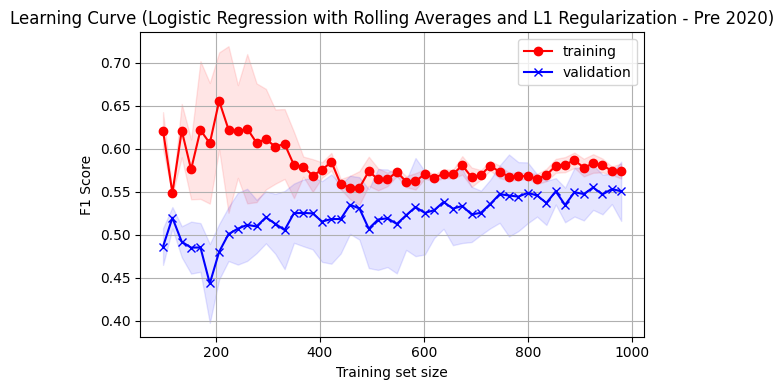

In [528]:
# pre 2020

# 1. Define target variable
df_pre2020['Win'] = (df_pre2020['Winner'] == df_pre2020['Team 1']).astype(int)

# 2. Select only differential features (rolling averages only)
all_diff_features = [col for col in df_pre2020.columns if col.startswith("Diff ") and df_pre2020[col].notna().all()]
diff_features = [col for col in all_diff_features if 'Games Played' not in col]

# 3. Create X and y
X = df_pre2020[diff_features].copy()
y = df_pre2020['Win']

# 4. Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 5. Train logistic regression with L1 regularization
model_pre2020 = LogisticRegression(penalty='l1', solver='liblinear', C=0.5, max_iter=1000)
model_pre2020.fit(X_train, y_train)

# 6. Evaluate model
y_pred = model_pre2020.predict(X_test)
accuracy_pre2020 = accuracy_score(y_test, y_pred)
f1_pre2020 = f1_score(y_test, y_pred)
report_pre2020 = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy_pre2020:.3f}")
print(f"F1 Score: {f1_score(y_test, y_pred):.3f}")
print("\nClassification Report:\n", report_pre2020)

# 7. Feature importance
coef_df = pd.DataFrame({
    'Feature': diff_features,
    'Coefficient': model_pre2020.coef_[0]
})

# Top 10 most important
top_features = coef_df.reindex(coef_df['Coefficient'].abs().sort_values(ascending=False).index).head(10)
print("\nTop 10 Most Important Features:")
print(top_features)

# Bottom 10 least important (including zeros)
bottom_features = coef_df.reindex(coef_df['Coefficient'].abs().sort_values(ascending=True).index).head(10)
print("\nBottom 10 Least Important (Most Regularized) Features:")
print(bottom_features)

# 8. Plot learning curve (use same model settings)
train_sizes, train_scores, val_scores = learning_curve(
    estimator=LogisticRegression(penalty='l1', solver='liblinear', C=0.5, max_iter=1000),
    X=X,
    y=y,
    train_sizes=np.linspace(0.1, 1.0, 50),
    cv=5,
    scoring=make_scorer(f1_score),
    n_jobs=-1,
    random_state=42
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# 9. Plotting
plt.figure(figsize=(6, 4))
plt.plot(train_sizes, train_mean, 'r-', label='training', marker='o')
plt.plot(train_sizes, val_mean, 'b-', label='validation', marker='x')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='red', alpha=0.1)
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, color='blue', alpha=0.1)
plt.xlabel('Training set size')
plt.ylabel('F1 Score')
plt.title('Learning Curve (Logistic Regression with Rolling Averages and L1 Regularization - Pre 2020)')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()


Accuracy: 0.731
F1 Score: 0.657

Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.82      0.78       207
           1       0.71      0.61      0.66       150

    accuracy                           0.73       357
   macro avg       0.73      0.71      0.72       357
weighted avg       0.73      0.73      0.73       357


Top 10 Most Important Features:
                             Feature  Coefficient
14                          Diff RPI     0.581337
11               Diff Average Margin     0.388453
13           Diff Turnovers per Game    -0.223574
24  Diff Goals per Game RollingAvg_3     0.122189
9                Diff Saves per Game    -0.119840
4          Diff Groundballs per Game     0.082760
26  Diff Average Margin RollingAvg_3     0.070025
0              Diff Assists per Game     0.051051
3               Diff Faceoff Percent     0.017734
12                 Diff Shot Percent     0.010258

Bottom 10 Least Important (Most 

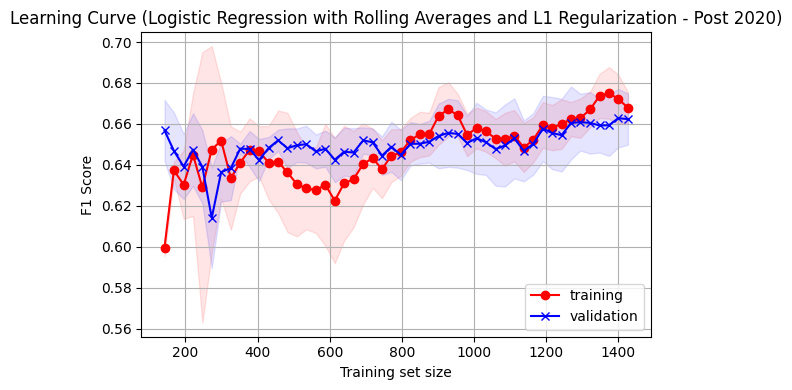

In [529]:
# post 2020
# 1. Define target variable
df_post2020['Win'] = (df_post2020['Winner'] == df_post2020['Team 1']).astype(int)

# 2. Select only differential features THAT ALSO are rolling averages
all_diff_features = [col for col in df_post2020.columns if col.startswith("Diff ") and df_post2020[col].notna().all()]
diff_features = [col for col in all_diff_features if 'Games Played' not in col]

# 3. Create X and y
X = df_post2020[diff_features].copy()
y = df_post2020['Win']

# 4. Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 5. Train logistic regression
model_post2020 = LogisticRegression(penalty='l1', solver='liblinear', C=0.05)
model_post2020.fit(X_train, y_train)

# 6. Evaluate model
y_pred = model_post2020.predict(X_test)
accuracy_post2020 = accuracy_score(y_test, y_pred)
f1_post2020 = f1_score(y_test, y_pred)
report_post2020 = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy_post2020:.3f}")
print(f"F1 Score: {f1_score(y_test, y_pred):.3f}")
print("\nClassification Report:\n", report_post2020)

# 7. Feature importance
coef_df = pd.DataFrame({
    'Feature': diff_features,
    'Coefficient': model_post2020.coef_[0]
})

# Top 10 most important
top_features = coef_df.reindex(coef_df['Coefficient'].abs().sort_values(ascending=False).index).head(10)
print("\nTop 10 Most Important Features:")
print(top_features)

# Bottom 10 least important (including zeros)
bottom_features = coef_df.reindex(coef_df['Coefficient'].abs().sort_values(ascending=True).index).head(10)
print("\nBottom 10 Least Important (Most Regularized) Features:")
print(bottom_features)

# 8. Plot learning curve
train_sizes, train_scores, val_scores = learning_curve(
    estimator=LogisticRegression(penalty='l1', solver='liblinear', C=0.05),
    X=X,
    y=y,
    train_sizes=np.linspace(0.1, 1.0, 50),
    cv=5,
    scoring=make_scorer(f1_score),
    n_jobs=-1,
    random_state=42
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# 9. Plotting
plt.figure(figsize=(6, 4))
plt.plot(train_sizes, train_mean, 'r-', label='training', marker='o')
plt.plot(train_sizes, val_mean, 'b-', label='validation', marker='x')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='red', alpha=0.1)
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, color='blue', alpha=0.1)
plt.xlabel('Training set size')
plt.ylabel('F1 Score')
plt.title('Learning Curve (Logistic Regression with Rolling Averages and L1 Regularization - Post 2020)')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()


#### Running Logistic Regression with L2 Regularization

In [533]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import classification_report, accuracy_score, make_scorer, f1_score

Accuracy: 0.690
F1 Score: 0.558

Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.81      0.76       150
           1       0.62      0.51      0.56        95

    accuracy                           0.69       245
   macro avg       0.67      0.66      0.66       245
weighted avg       0.68      0.69      0.68       245


Top 10 Most Important Features:
                                   Feature  Coefficient
13                                Diff RPI     0.190502
12                 Diff Turnovers per Game    -0.149194
8                      Diff Saves per Game    -0.141652
10                     Diff Average Margin     0.115175
9              Diff Goals Allowed per Game    -0.109162
25          Diff Shot Percent RollingAvg_3     0.105905
0                    Diff Assists per Game     0.101155
28                   Diff RPI RollingAvg_3     0.095373
18       Diff Faceoff Percent RollingAvg_3     0.091454
19  Diff Groundballs pe

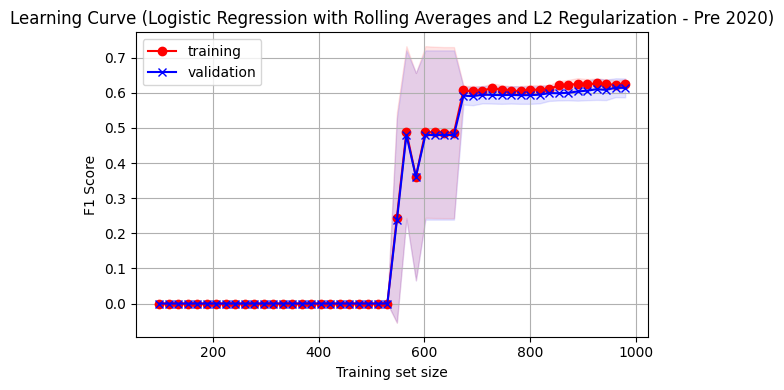

In [534]:
# pre 2020

# 1. Define target variable
df_pre2020['Win'] = (df_pre2020['Winner'] == df_pre2020['Team 1']).astype(int)

# 2. Select only differential features (rolling averages only)
all_diff_features = [col for col in df_pre2020.columns if col.startswith("Diff ") and df_pre2020[col].notna().all()]
diff_features = [col for col in all_diff_features if 'Games Played' not in col]

# 3. Create X and y
X = df_pre2020[diff_features].copy()
y = df_pre2020['Win']

# 4. Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 5. Train logistic regression with L1 regularization
model_pre2020 = LogisticRegression(penalty='l2', solver='liblinear', C=0.01, max_iter=1000)
model_pre2020.fit(X_train, y_train)

# 6. Evaluate model
y_pred = model_pre2020.predict(X_test)
accuracy_pre2020 = accuracy_score(y_test, y_pred)
f1_pre2020 = f1_score(y_test, y_pred)
report_pre2020 = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy_pre2020:.3f}")
print(f"F1 Score: {f1_score(y_test, y_pred):.3f}")
print("\nClassification Report:\n", report_pre2020)

# 7. Feature importance
coef_df = pd.DataFrame({
    'Feature': diff_features,
    'Coefficient': model_pre2020.coef_[0]
})

# Top 10 most important
top_features = coef_df.reindex(coef_df['Coefficient'].abs().sort_values(ascending=False).index).head(10)
print("\nTop 10 Most Important Features:")
print(top_features)

# Bottom 10 least important (including zeros)
bottom_features = coef_df.reindex(coef_df['Coefficient'].abs().sort_values(ascending=True).index).head(10)
print("\nBottom 10 Least Important (Most Regularized) Features:")
print(bottom_features)

# 8. Plot learning curve (use same model settings)
train_sizes, train_scores, val_scores = learning_curve(
    estimator=LogisticRegression(penalty='l1', solver='liblinear', C=0.01, max_iter=1000),
    X=X,
    y=y,
    train_sizes=np.linspace(0.1, 1.0, 50),
    cv=5,
    scoring=make_scorer(f1_score),
    n_jobs=-1,
    random_state=42
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# 9. Plotting
plt.figure(figsize=(6, 4))
plt.plot(train_sizes, train_mean, 'r-', label='training', marker='o')
plt.plot(train_sizes, val_mean, 'b-', label='validation', marker='x')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='red', alpha=0.1)
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, color='blue', alpha=0.1)
plt.xlabel('Training set size')
plt.ylabel('F1 Score')
plt.title('Learning Curve (Logistic Regression with Rolling Averages and L2 Regularization - Pre 2020)')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()


Accuracy: 0.714
F1 Score: 0.648

Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.78      0.76       207
           1       0.67      0.63      0.65       150

    accuracy                           0.71       357
   macro avg       0.71      0.70      0.70       357
weighted avg       0.71      0.71      0.71       357


Top 10 Most Important Features:
                             Feature  Coefficient
14                          Diff RPI     0.395340
13           Diff Turnovers per Game    -0.203020
10       Diff Goals Allowed per Game    -0.126723
11               Diff Average Margin     0.125587
12                 Diff Shot Percent     0.095033
9                Diff Saves per Game    -0.086365
8                Diff Goals per Game     0.083197
26  Diff Average Margin RollingAvg_3     0.078578
4          Diff Groundballs per Game     0.078113
3               Diff Faceoff Percent     0.078004

Bottom 10 Least Important (Most 

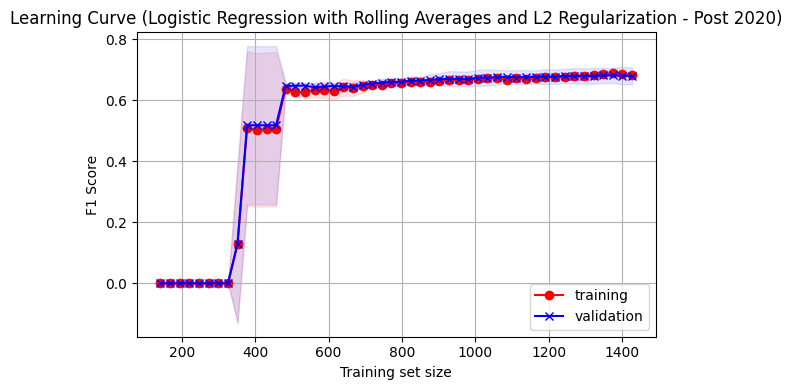

In [535]:
# post 2020
# 1. Define target variable
df_post2020['Win'] = (df_post2020['Winner'] == df_post2020['Team 1']).astype(int)

# 2. Select only differential features THAT ALSO are rolling averages
all_diff_features = [col for col in df_post2020.columns if col.startswith("Diff ") and df_post2020[col].notna().all()]
diff_features = [col for col in all_diff_features if 'Games Played' not in col]

# 3. Create X and y
X = df_post2020[diff_features].copy()
y = df_post2020['Win']

# 4. Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 5. Train logistic regression
model_post2020 = LogisticRegression(penalty='l2', solver='liblinear', C=0.01)
model_post2020.fit(X_train, y_train)

# 6. Evaluate model
y_pred = model_post2020.predict(X_test)
accuracy_post2020 = accuracy_score(y_test, y_pred)
f1_post2020 = f1_score(y_test, y_pred)
report_post2020 = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy_post2020:.3f}")
print(f"F1 Score: {f1_score(y_test, y_pred):.3f}")
print("\nClassification Report:\n", report_post2020)

# 7. Feature importance
coef_df = pd.DataFrame({
    'Feature': diff_features,
    'Coefficient': model_post2020.coef_[0]
})

# Top 10 most important
top_features = coef_df.reindex(coef_df['Coefficient'].abs().sort_values(ascending=False).index).head(10)
print("\nTop 10 Most Important Features:")
print(top_features)

# Bottom 10 least important (including zeros)
bottom_features = coef_df.reindex(coef_df['Coefficient'].abs().sort_values(ascending=True).index).head(10)
print("\nBottom 10 Least Important (Most Regularized) Features:")
print(bottom_features)

# 8. Plot learning curve
train_sizes, train_scores, val_scores = learning_curve(
    estimator=LogisticRegression(penalty='l1', solver='liblinear', C=0.01),
    X=X,
    y=y,
    train_sizes=np.linspace(0.1, 1.0, 50),
    cv=5,
    scoring=make_scorer(f1_score),
    n_jobs=-1,
    random_state=42
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# 9. Plotting
plt.figure(figsize=(6, 4))
plt.plot(train_sizes, train_mean, 'r-', label='training', marker='o')
plt.plot(train_sizes, val_mean, 'b-', label='validation', marker='x')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='red', alpha=0.1)
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, color='blue', alpha=0.1)
plt.xlabel('Training set size')
plt.ylabel('F1 Score')
plt.title('Learning Curve (Logistic Regression with Rolling Averages and L2 Regularization - Post 2020)')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()
